### EDA Polymarket Data on Politics and Global Politics

In [2]:
%run eda_starter_template.py


[Memory] Initial memory usage: 266.25 MB

Loading Bitcoin data from /Users/mig/Documents/LSE/Capstone Project/lse-bitcoin-analytics-capstone-template/data/Coin Metrics/coinmetrics_btc.csv...
[Memory] Before loading Bitcoin data: 266.25 MB
[Memory] After loading Bitcoin data: 269.91 MB (Δ 3.66 MB)
Error loading Bitcoin data: No such file or directory (os error 2): ...ne Project/lse-bitcoin-analytics-capstone-template/data/Coin Metrics/coinmetrics_btc.csv (set POLARS_VERBOSE=1 to see full path)

This error occurred with the following context stack:
	[1] 'csv scan'
	[2] 'with_columns'
	[3] 'sink'

Loading Polymarket data from /Users/mig/Documents/LSE/Capstone Project/lse-bitcoin-analytics-capstone-template/data/Polymarket...
[Memory] Before loading Polymarket data: 269.92 MB
[Memory] After loading Polymarket data: 269.92 MB (Δ 0.00 MB)

[Memory] Final memory usage: 269.92 MB (Total Δ: 3.67 MB)

EDA Layout Complete. Check the 'plots' directory for visualizations.


In [3]:
import os
import pandas as pd

COINMETRICS_PATH = '/Users/mig/Documents/LSE/Capstone Project/lse-bitcoin-analytics-capstone-template/eda/data/Coin Metrics/coinmetrics_btc.csv'
POLYMARKET_DIR = '/Users/mig/Documents/LSE/Capstone Project/lse-bitcoin-analytics-capstone-template/eda/data/Polymarket'

# Load Bitcoin data
btc_df = load_bitcoin_data(COINMETRICS_PATH)

# Debug: Check directory and files
print("\n" + "="*80)
print("POLYMARKET DATA LOADING")
print("="*80)
print(f"\nDirectory: {POLYMARKET_DIR}")
print(f"Directory exists: {os.path.exists(POLYMARKET_DIR)}")

if os.path.exists(POLYMARKET_DIR):
    print("\nFiles in directory:")
    all_files = os.listdir(POLYMARKET_DIR)
    for file in sorted(all_files):
        filepath = os.path.join(POLYMARKET_DIR, file)
        size = os.path.getsize(filepath) / (1024*1024)  # Size in MB
        print(f"  {file:50s} ({size:.2f} MB)")
else:
    print("\n✗ ERROR: Directory does not exist!")

print("\n" + "-"*80)

# Load Polymarket data with DETAILED error messages
poly_data = {}

files_to_load = [
    ('markets', 'finance_politics_markets.parquet'),
    ('odds_history', 'finance_politics_odds_history.parquet'),
    ('summary', 'finance_politics_summary.parquet'),
    ('tokens', 'finance_politics_tokens.parquet'), 
    ('trades', 'finance_politics_trades.parquet'),
    ('event_stats', 'finance_politics_event_stats.parquet')
]

for name, filename in files_to_load:
    filepath = os.path.join(POLYMARKET_DIR, filename)
    
    print(f"\n{name}:")
    print(f"  Looking for: {filename}")
    print(f"  Full path: {filepath}")
    print(f"  File exists: {os.path.exists(filepath)}")
    
    if not os.path.exists(filepath):
        print(f"  ✗ SKIPPED: File not found")
        continue
    
    try:
        poly_data[name] = pd.read_parquet(filepath)
        print(f"  ✓ SUCCESS: Loaded {len(poly_data[name]):,} rows, {len(poly_data[name].columns)} columns")
        print(f"  Columns: {', '.join(poly_data[name].columns[:5].tolist())}{'...' if len(poly_data[name].columns) > 5 else ''}")
        
    except Exception as e:
        print(f"  ✗ ERROR: {type(e).__name__}")
        print(f"  Message: {str(e)}")

# Final summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Bitcoin data: ✓ {len(btc_df):,} rows")
print(f"Polymarket datasets loaded: {len(poly_data)}/{len(files_to_load)}")

if len(poly_data) > 0:
    for name, df in poly_data.items():
        print(f"  ✓ {name:15s}: {len(df):,} rows")
else:
    print("\n⚠ WARNING: No Polymarket files loaded!")
    print("\nPossible reasons:")
    print("  1. Files have different names than expected")
    print("  2. Files are in a different directory")
    print("  3. Files haven't been downloaded yet")
    print("  4. pyarrow library not installed (run: pip install pyarrow)")

print("="*80)

Loading Bitcoin data from /Users/mig/Documents/LSE/Capstone Project/lse-bitcoin-analytics-capstone-template/eda/data/Coin Metrics/coinmetrics_btc.csv...
[Memory] Before loading Bitcoin data: 270.61 MB
[Memory] After loading Bitcoin data: 286.78 MB (Δ 16.17 MB)
Successfully loaded 6221 rows.

POLYMARKET DATA LOADING

Directory: /Users/mig/Documents/LSE/Capstone Project/lse-bitcoin-analytics-capstone-template/eda/data/Polymarket
Directory exists: True

Files in directory:
  finance_politics_event_stats.parquet               (1.37 MB)
  finance_politics_markets.parquet                   (3.22 MB)
  finance_politics_odds_history.parquet              (16.96 MB)
  finance_politics_summary.parquet                   (4.31 MB)
  finance_politics_tokens.parquet                    (9.87 MB)
  finance_politics_trades.parquet                    (3156.20 MB)
  polymarket_btc_analytics_schema.md                 (0.00 MB)

-------------------------------------------------------------------------------

In [4]:
def get_cleaned_poly_data(data):
    """
    Applies the audit logic to edit timestamps in-place 
    and returns the cleaned dictionary.
    """
    if not data:
        return {}

    threshold = pd.Timestamp("2020-01-01")
    
    # We iterate over the dictionary keys just like your original script
    for key, df in data.items():
        for col in df.columns:
            # Check if column is a timestamp-related column
            if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                
                # 1. Ensure numeric conversion (handles mixed types)
                temp_numeric = pd.to_numeric(df[col], errors='coerce')
                
                # 2. Apply the "1970 Fix" 
                # If the max value is huge (> 10^12), it's milliseconds
                if temp_numeric.max() > 10**12:
                    df[col] = pd.to_datetime(temp_numeric, unit='ms', errors='coerce')
                else:
                    df[col] = pd.to_datetime(temp_numeric, unit='s', errors='coerce')
                
                # 3. Clean remaining outliers (forcing any odd 1970 dates to NaT)
                df.loc[df[col] < threshold, col] = pd.NaT
                
    return data

if __name__ == "__main__":
    # 1. Load your original data
    # poly_data = load_polymarket_data()
    
    # 2. Clean and rename to poly_data_clean
    poly_data_clean = get_cleaned_poly_data(poly_data)
    
    print("Success: poly_data_clean is ready for use.")

Success: poly_data_clean is ready for use.


### Content
1. Understand Data Polymarket(Politics) 
    - Extract Data to get politics related data
    - Import bitcoin data
2. Correlation between btc price and polymarket in politics
    - number of markets

In [5]:
import os
import pandas as pd

# Define the file path
markets_file_path = os.path.join(POLYMARKET_DIR, 'finance_politics_markets.parquet')

# Load the data directly
markets_data = pd.read_parquet(markets_file_path)



In [6]:
category = markets_data.groupby('category')
print(category.groups.keys())
category.size()
# 1. Define your keyword map
keyword_map = {
    'Crypto': 'bitcoin|eth|solana|crypto|token|airdrop',
    'Politics': 'trump|biden|harris|election|senate|republican|democrat',
    'Ukraine & Russia': 'ukraine|russia|putin|zelensky|kremlin',
    'Pop-Culture': 'oscars|grammy|taylor swift|box office|celebrity',
    'Tech': 'ai|openai|gpt|google|nvidia|meta|apple',
    'Global Politics': 'israel|gaza|iran|china|taiwan|uk|london'
}

# 2. Filter for only the rows where category is blank
blank_mask = (markets_data['category'] == '') | (markets_data['category'].isna())

# 3. Loop through the map and update blank categories based on question text
for cat, keywords in keyword_map.items():
    # Only update if the row is currently blank AND the question contains a keyword
    match_mask = blank_mask & markets_data['question'].str.contains(keywords, case=False, na=False)
    markets_data.loc[match_mask, 'category'] = cat

# 4. See how many are left blank now
print(markets_data['category'].value_counts())

dict_keys(['', 'Business', 'Coronavirus', 'Coronavirus-', 'Crypto', 'Global Politics', 'Politics', 'Pop-Culture ', 'Tech', 'US-current-affairs', 'Ukraine & Russia'])
category
Crypto                57852
Politics              10909
                       7421
Tech                    766
Global Politics         694
Ukraine & Russia        293
US-current-affairs      265
Business                113
Pop-Culture               4
Coronavirus               3
Coronavirus-              1
Name: count, dtype: int64


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import polars as pl

In [8]:
# polymarket market
poly_market_politics = markets_data[(markets_data['category'] == 'Politics')|(markets_data['category'] == 'Global Politics')]
display(poly_market_politics)
# polymarket event stats
poly_event_stats_politics = pd.merge(poly_market_politics['event_slug'],poly_data_clean['event_stats'], on = 'event_slug', how = 'left')
# display(poly_event_stats_politics)
# polymarket odds history
poly_odds_history_politics = pd.merge(poly_data_clean['odds_history'], poly_market_politics[['market_id', 'question']], on = 'market_id', how = 'left')
poly_odds_history_politics_clean = poly_odds_history_politics.dropna()
# display(poly_odds_history_politics_clean)
# polymarket summary
poly_summary_politics = pd.merge(poly_market_politics['market_id'], poly_data_clean['summary'], on = 'market_id', how = 'left')
# display(poly_summary_politics)
# polymarket tokens
poly_tokens_politics = pd.merge(poly_data_clean['tokens'], poly_market_politics[['market_id', 'question']], on = 'market_id', how = 'left')
poly_tokens_politics_clean = poly_tokens_politics.dropna()
# display(poly_tokens_politics_clean)
# polymarket trades
poly_trades_politics = pd.merge(poly_data_clean['trades'][['market_id','token_id','timestamp','price','size','side']],poly_market_politics[['market_id', 'question']],  on = 'market_id', how = 'left')
poly_trades_politics_clean = poly_trades_politics.dropna()
# display(poly_trades_politics_clean)


,market_id,question,slug,event_slug,category,volume,active,closed,created_at,end_date
0,242851,Will Bongbong Marcos be elected President of t...,will-bongbong-marcos-be-elected-president-of-t...,will-bongbong-marcos-be-elected-president-of-t...,Global Politics,21533.53,True,True,2022-04-05 20:37:30,2022-05-09
6,243194,Will Gustavo Petro win the 2022 Colombian pres...,will-gustavo-petro-win-the-2022-colombian-pres...,who-will-win-the-2022-colombian-presidential-e...,Global Politics,29408.39,True,True,2022-04-13 02:00:35,2022-05-29
7,243195,Will Federico Gutiérrez win the 2022 Colombian...,will-federico-gutirrez-win-the-2022-colombian-...,who-will-win-the-2022-colombian-presidential-e...,Global Politics,4606.35,True,True,2022-04-13 02:02:34,2022-05-29
8,243196,Will Sergio Fajardo win the 2022 Colombian pre...,will-sergio-fajardo-win-the-2022-colombian-pre...,who-will-win-the-2022-colombian-presidential-e...,Global Politics,647.64,True,True,2022-04-13 02:07:33,2022-05-29
13,246486,2022 French Legislative Election: Will Macron'...,2022-french-legislative-election-will-macrons-...,2022-french-legislative-election-will-macrons-...,Global Politics,6410.48,True,True,2022-06-06 14:16:14,2022-06-20
...,...,...,...,...,...,...,...,...,...,...
78262,241654,"Will the Canadian ""Emergencies Act"" be revoked...",will-the-canadian-emergencies-act-be-lifted-by...,will-the-canadian-emergencies-act-be-lifted-by...,Global Politics,9246.32,True,True,2022-02-23 17:09:43,2022-03-07
78273,241789,Will the Ukrainian Government receive more tha...,will-the-ukrainian-government-receive-more-tha...,will-the-ukrainian-government-receive-more-tha...,Global Politics,32071.31,True,True,2022-03-01 01:01:35,2022-03-10
78289,241997,Will Marine Le Pen win 2nd place in the first ...,will-marine-le-pen-win-2nd-place-in-the-first-...,will-marine-le-pen-win-2nd-place-in-the-first-...,Global Politics,166568.45,True,True,2022-03-09 21:27:48,2022-04-10
78317,242686,2022 Hungarian elections: Will Fidesz win at l...,2022-hungarian-elections-will-fidesz-retain-at...,2022-hungarian-elections-will-fidesz-retain-at...,Global Politics,16801.37,True,True,2022-03-31 21:11:06,2022-04-03


In [9]:

# summary
print('politics market info', poly_market_politics.info())
print('politics event stats info', poly_event_stats_politics.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11603 entries, 0 to 78319
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   market_id   11603 non-null  object        
 1   question    11603 non-null  object        
 2   slug        11603 non-null  object        
 3   event_slug  11603 non-null  object        
 4   category    11603 non-null  object        
 5   volume      11603 non-null  float64       
 6   active      11603 non-null  bool          
 7   closed      11603 non-null  bool          
 8   created_at  11603 non-null  datetime64[us]
 9   end_date    11269 non-null  datetime64[us]
dtypes: bool(2), datetime64[us](2), float64(1), object(5)
memory usage: 838.5+ KB
politics market info None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11603 entries, 0 to 11602
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----  

In [10]:
print('politics odds history info', poly_odds_history_politics_clean.info())
print('politics summary info', poly_summary_politics.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1186369 entries, 0 to 2143150
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   market_id  1186369 non-null  object        
 1   token_id   1186369 non-null  object        
 2   timestamp  1186369 non-null  datetime64[ns]
 3   price      1186369 non-null  float64       
 4   question   1186369 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 54.3+ MB
politics odds history info None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11603 entries, 0 to 11602
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   market_id    11603 non-null  object        
 1   question     11603 non-null  object        
 2   slug         11603 non-null  object        
 3   volume       11603 non-null  float64       
 4   active       11603 non-null  bool      

In [ ]:
print('politics tokens info', poly_tokens_politics_clean.info())
print('politics trades info', poly_trades_politics_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23204 entries, 176 to 156407
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   market_id  23204 non-null  object
 1   token_id   23204 non-null  object
 2   outcome    23204 non-null  object
 3   question   23204 non-null  object
dtypes: object(4)
memory usage: 906.4+ KB
politics tokens info None
<class 'pandas.core.frame.DataFrame'>
Index: 2648595 entries, 1829145 to 27013723
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   market_id  object        
 1   token_id   object        
 2   timestamp  datetime64[ns]
 3   price      float64       
 4   size       float64       
 5   side       object        
 6   question   object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 161.7+ MB
politics trades info None


In [14]:
print("Preparing BTC data...")
btc_pd = btc_df.to_pandas() if hasattr(btc_df, 'to_pandas') else btc_df
btc_pd['time'] = pd.to_datetime(btc_pd['time'])
btc_pd['date'] = btc_pd['time'].dt.date

# Simple daily average (no min/max)
btc_daily_simple = btc_pd.groupby('date')['PriceUSD'].mean().reset_index()
btc_daily_simple.columns = ['date', 'btc_price']
btc_daily_simple['btc_pct_change'] = btc_daily_simple['btc_price'].pct_change() * 100

print(f"✓ BTC daily data: {len(btc_daily_simple)} days")


Preparing BTC data...
✓ BTC daily data: 6221 days


/var/folders/hn/pyg79cw15ql332wmddc7h_6c0000gn/T/ipykernel_41962/1981144949.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  btc_daily_simple['btc_pct_change'] = btc_daily_simple['btc_price'].pct_change() * 100


In [17]:
# ============================================================================
# MERGE WITH POLITICS DATA
# ============================================================================

# Markets
poly_market_politics['created_at'] = pd.to_datetime(poly_market_politics['created_at'])
poly_market_politics['created_date'] = poly_market_politics['created_at'].dt.date

poly_market_btc = pd.merge(
    poly_market_politics,
    btc_daily_simple,
    left_on='created_date',
    right_on='date',
    how='left'
)

# Trades
poly_trades_politics_clean['timestamp'] = pd.to_datetime(
    poly_trades_politics_clean['timestamp'], 
    errors='coerce'
)
poly_trades_politics_clean['trade_date'] = poly_trades_politics_clean['timestamp'].dt.date

poly_trades_btc = pd.merge(
    poly_trades_politics_clean,
    btc_daily_simple,
    left_on='trade_date',
    right_on='date',
    how='left'
)

print(f"✓ Markets merged: {len(poly_market_btc):,}")
print(f"✓ Trades merged: {len(poly_trades_btc):,}")


/var/folders/hn/pyg79cw15ql332wmddc7h_6c0000gn/T/ipykernel_41962/3136786358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly_market_politics['created_at'] = pd.to_datetime(poly_market_politics['created_at'])
/var/folders/hn/pyg79cw15ql332wmddc7h_6c0000gn/T/ipykernel_41962/3136786358.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly_market_politics['created_date'] = poly_market_politics['created_at'].dt.date
/var/folders/hn/pyg79cw15ql332wmddc7h_6c0000gn/T/ipykernel_41962/3136786358.py:18: Set

✓ Markets merged: 11,603
✓ Trades merged: 2,648,595



MARKET CREATION vs BTC PRICE CHANGE
Correlation: -0.0167
P-value: 0.6693
Sample size: 654


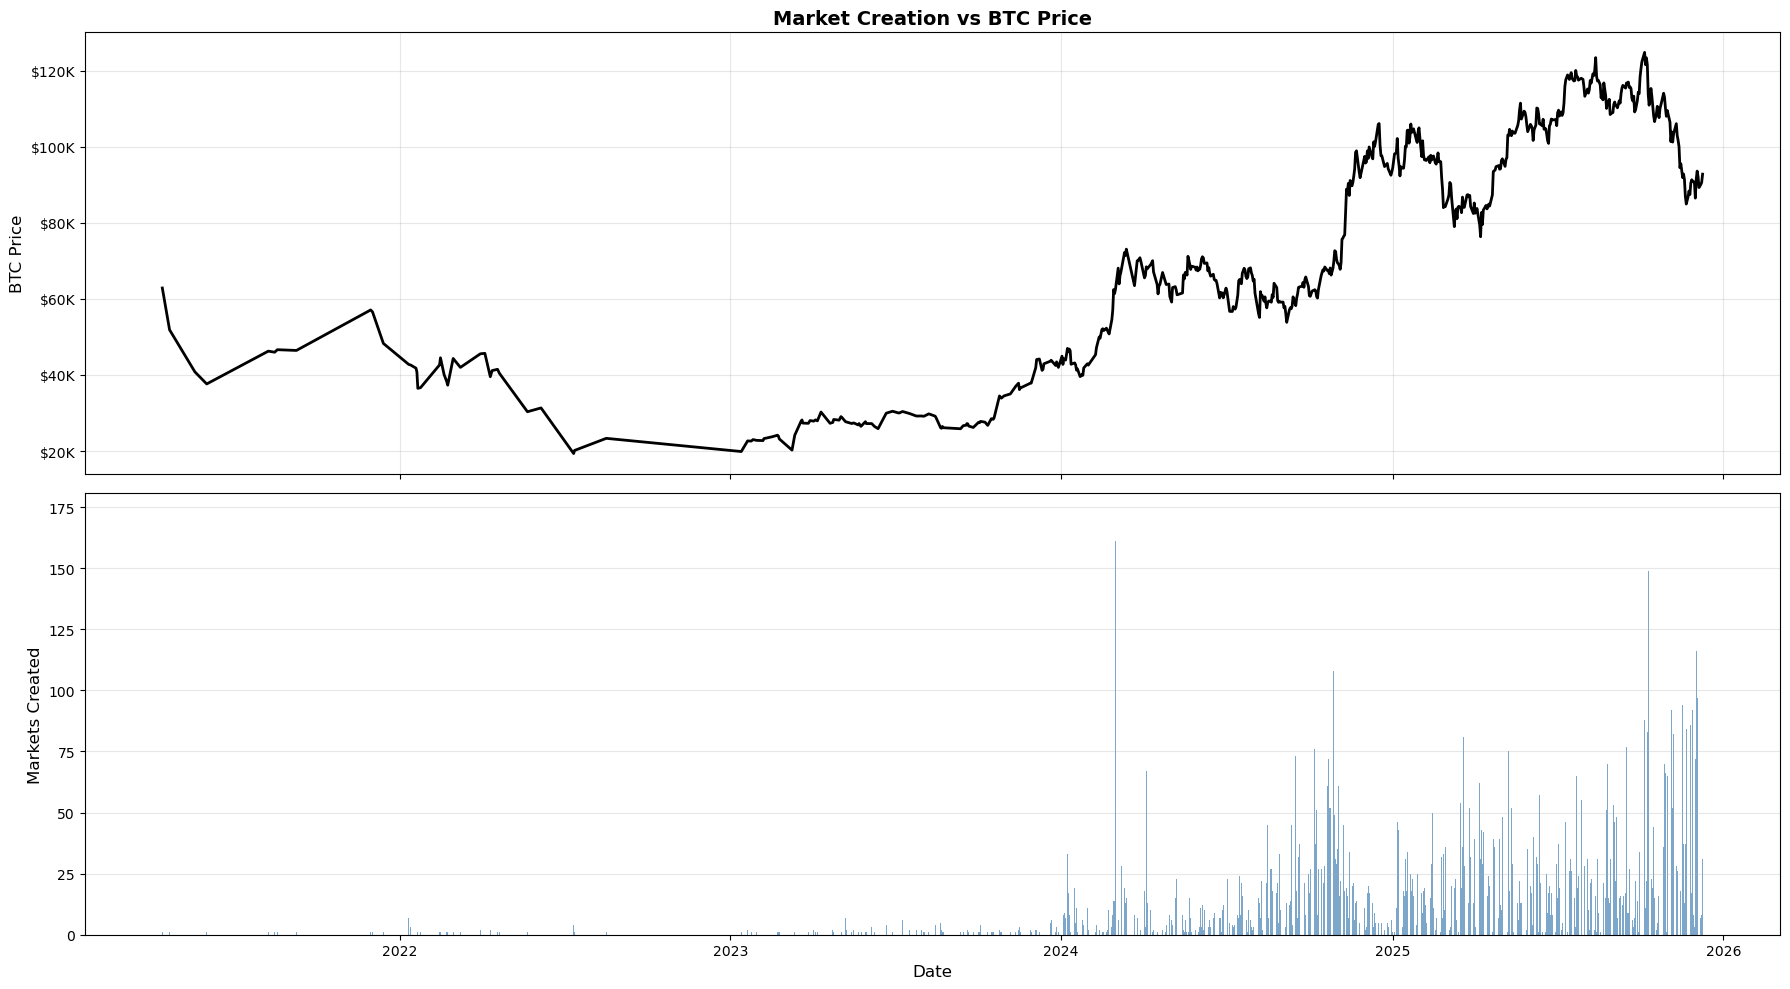

In [18]:

# Daily aggregation - FILTER OUT ZEROS
daily_markets = poly_market_btc.groupby('created_date').agg({
    'market_id': 'count',
    'btc_price': 'mean'
}).reset_index()

daily_markets.columns = ['date', 'num_markets', 'btc_price']
daily_markets = daily_markets[daily_markets['num_markets'] > 0]  # REMOVE ZEROS

# Calculate BTC change
daily_markets['btc_pct_change'] = daily_markets['btc_price'].pct_change() * 100
daily_markets = daily_markets.dropna()  # REMOVE NaN

# Correlation
if len(daily_markets) > 10:
    corr_creation, pval_creation = pearsonr(
        daily_markets['num_markets'], 
        daily_markets['btc_pct_change']
    )
    
    print("\n" + "="*80)
    print("MARKET CREATION vs BTC PRICE CHANGE")
    print("="*80)
    print(f"Correlation: {corr_creation:.4f}")
    print(f"P-value: {pval_creation:.4f}")
    print(f"Sample size: {len(daily_markets)}")
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    
    # BTC Price
    ax1.plot(pd.to_datetime(daily_markets['date']), daily_markets['btc_price'],
             color='black', linewidth=2)
    ax1.set_ylabel('BTC Price', fontsize=12)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    ax1.grid(alpha=0.3)
    ax1.set_title('Market Creation vs BTC Price', fontsize=14, fontweight='bold')
    
    # Markets created
    ax2.bar(pd.to_datetime(daily_markets['date']), daily_markets['num_markets'],
            color='steelblue', alpha=0.7)
    ax2.set_ylabel('Markets Created', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('market_creation_analysis.png', dpi=300)
    plt.show()



MONTHLY SUMMARY
         date  num_markets  total_volume      btc_price
41 2025-03-01          586  2.560865e+08   84873.511801
42 2025-04-01          627  5.152724e+08   85639.260015
43 2025-05-01          582  2.124013e+08  102899.980452
44 2025-06-01          386  9.406946e+07  105764.903154
45 2025-07-01          572  6.548924e+08  115568.154570
46 2025-08-01          488  2.866547e+07  113908.291130
47 2025-09-01          548  4.917924e+07  113404.282381
48 2025-10-01          874  3.193384e+07  114848.864490
49 2025-11-01         1348  3.886526e+07   95307.871140
50 2025-12-01          561  3.169436e+06   91133.646141


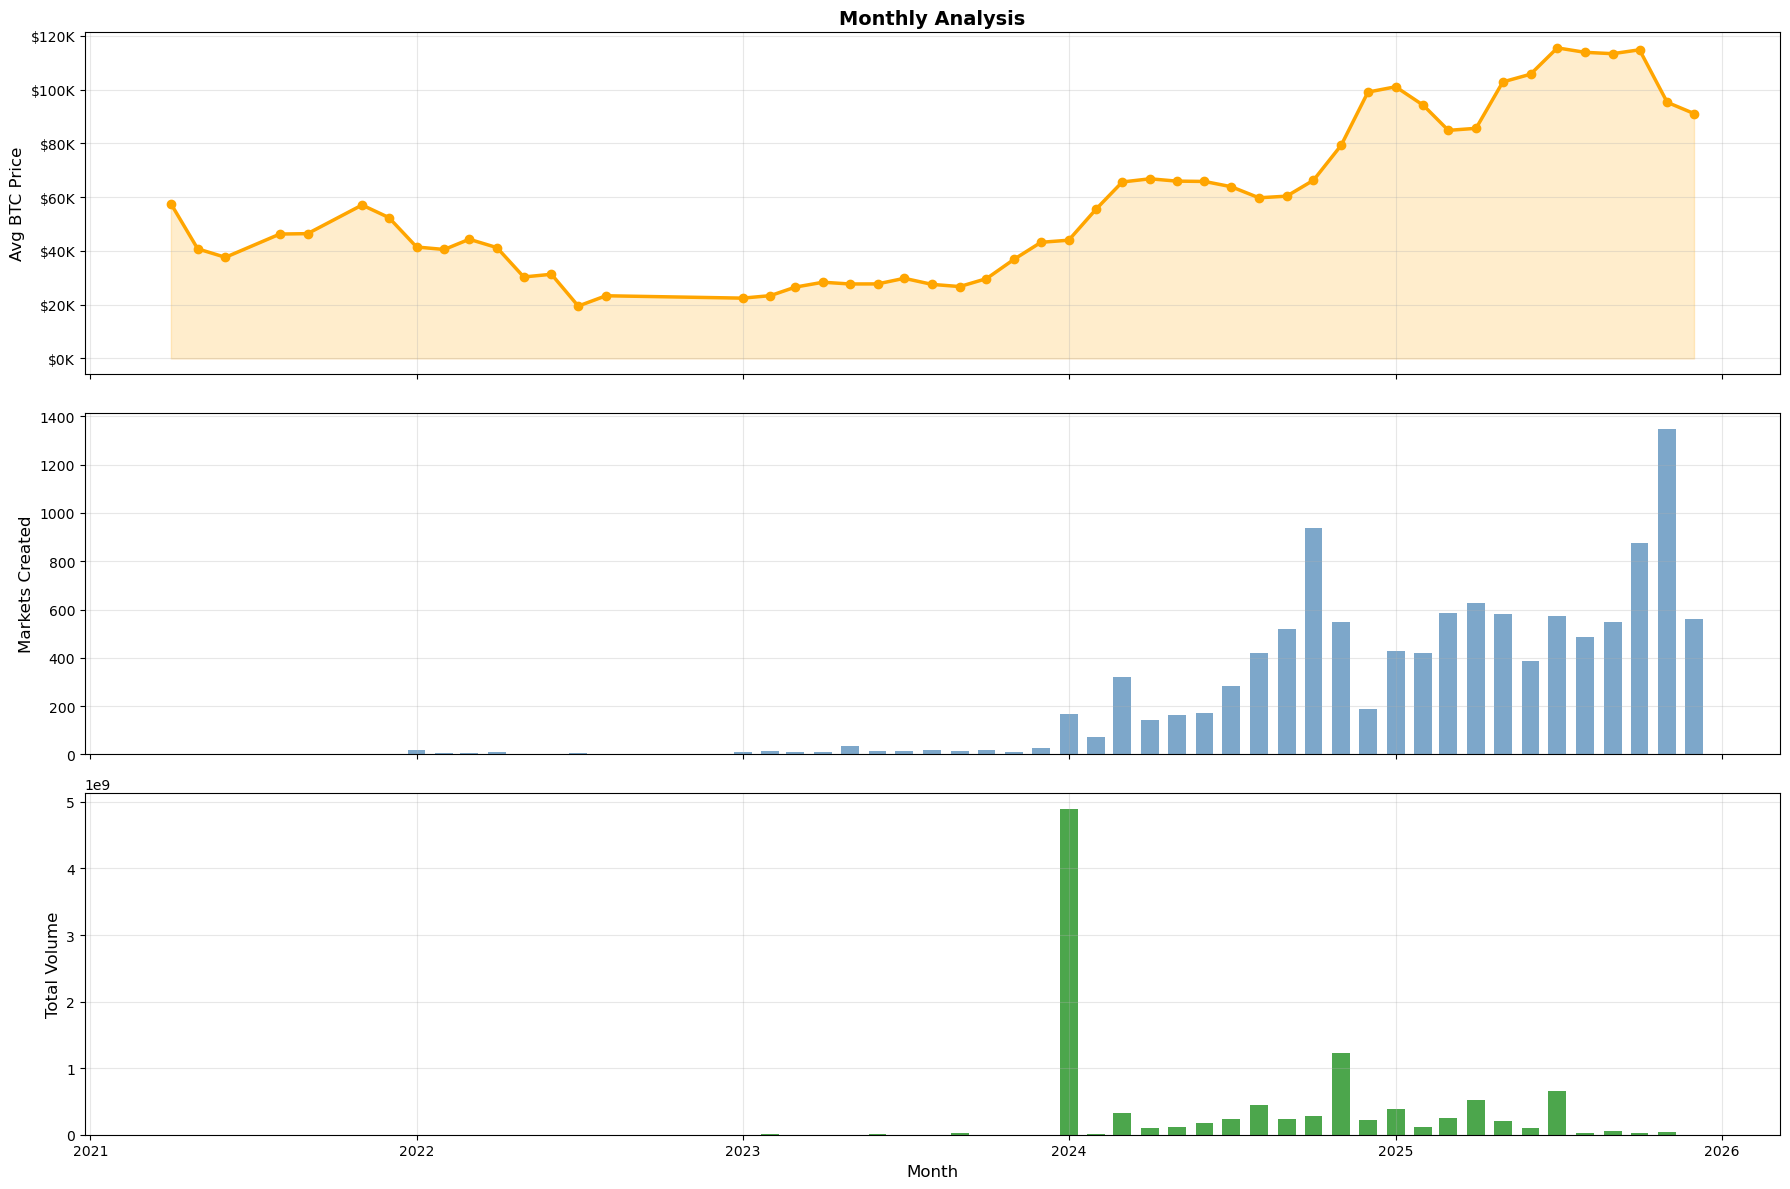

In [19]:

# Monthly aggregation
poly_market_btc['year_month'] = pd.to_datetime(poly_market_btc['created_at']).dt.to_period('M').dt.to_timestamp()

monthly_markets = poly_market_btc.groupby('year_month').agg({
    'market_id': 'count',
    'volume': 'sum',
    'btc_price': 'mean'
}).reset_index()

monthly_markets.columns = ['date', 'num_markets', 'total_volume', 'btc_price']
monthly_markets = monthly_markets[monthly_markets['num_markets'] > 0]  # Remove zeros

print("\n" + "="*80)
print("MONTHLY SUMMARY")
print("="*80)
print(monthly_markets[['date', 'num_markets', 'total_volume', 'btc_price']].tail(10))

# Plot
fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

# BTC Price
axes[0].plot(monthly_markets['date'], monthly_markets['btc_price'],
             marker='o', linewidth=2.5, markersize=6, color='orange')
axes[0].fill_between(monthly_markets['date'], monthly_markets['btc_price'],
                     alpha=0.2, color='orange')
axes[0].set_ylabel('Avg BTC Price', fontsize=12)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[0].grid(alpha=0.3)
axes[0].set_title('Monthly Analysis', fontsize=14, fontweight='bold')

# Markets created
axes[1].bar(monthly_markets['date'], monthly_markets['num_markets'],
            width=20, color='steelblue', alpha=0.7)
axes[1].set_ylabel('Markets Created', fontsize=12)
axes[1].grid(alpha=0.3)

# Volume
axes[2].bar(monthly_markets['date'], monthly_markets['total_volume'],
            width=20, color='green', alpha=0.7)
axes[2].set_ylabel('Total Volume', fontsize=12)
axes[2].set_xlabel('Month', fontsize=12)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('monthly_analysis.png', dpi=300)
plt.show()


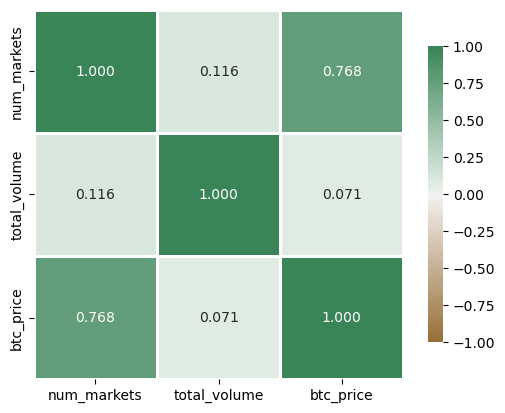

In [20]:

correlation_monthly_markets = monthly_markets[['num_markets', 'total_volume', 'btc_price']].corr()

axis_corr = sns.heatmap(
correlation_monthly_markets,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
square=True,
annot=True,
fmt='.3f',               
linewidths=2,            
cbar_kws={"shrink": 0.8} 
)

plt.show()


TOP 20 MARKETS BY VOLUME
                                                                   question       volume          created_at
                   Will Donald Trump win the 2024 US Presidential Election? 1.531479e+09 2024-01-04 17:33:51
                  Will Kamala Harris win the 2024 US Presidential Election? 1.037039e+09 2024-01-04 17:40:17
                                          Will Donald Trump be inaugurated? 4.004095e+08 2024-11-01 20:59:58
            Will Nicolae Ciucă win the 2024 Romanian Presidential election? 3.265077e+08 2024-11-07 23:53:29
Will any other Republican Politician win the 2024 US Presidential Election? 2.416551e+08 2024-01-06 19:52:35
                                       Kamala Harris wins the popular vote? 1.637798e+08 2024-01-09 18:29:49
                 Will Michelle Obama win the 2024 US Presidential Election? 1.533823e+08 2024-01-05 20:53:17
                     Will Zohran Mamdani win the 2025 NYC mayoral election? 1.432549e+08 2025-04-22 15

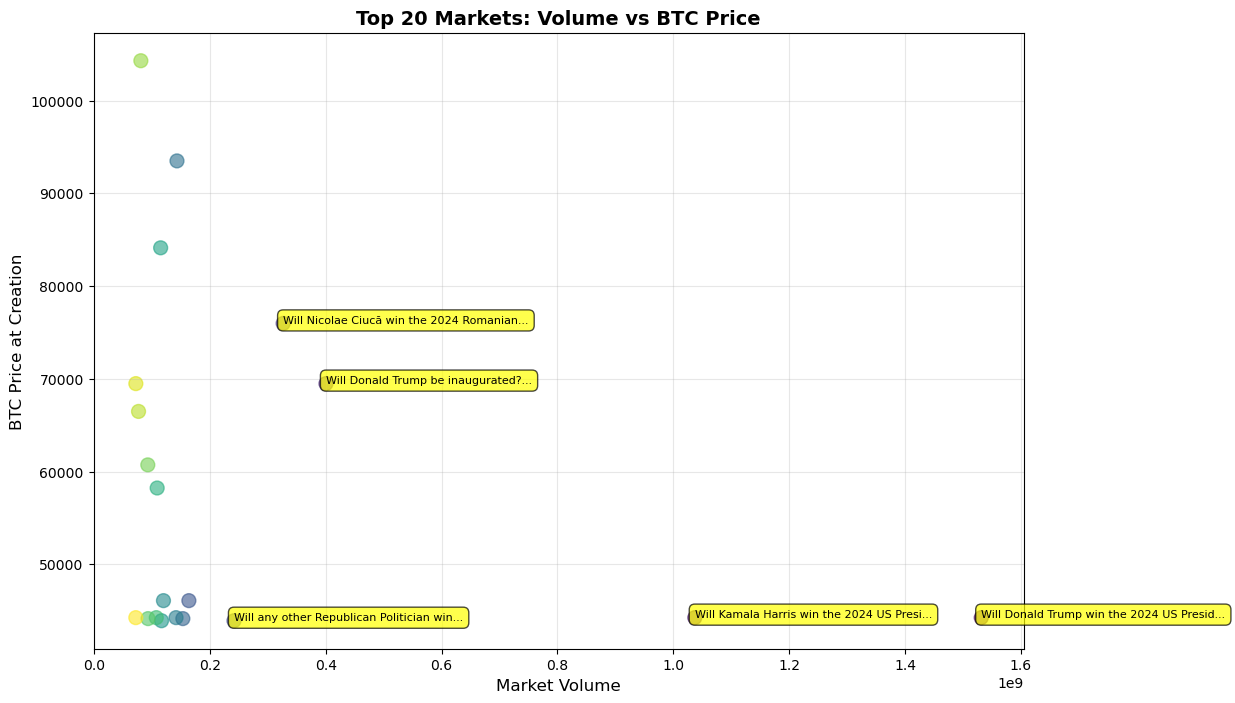

In [21]:

# Top volume markets
top_volume = poly_market_btc.nlargest(20, 'volume')

print("\n" + "="*80)
print("TOP 20 MARKETS BY VOLUME")
print("="*80)
print(top_volume[['question', 'volume', 'created_at']].to_string(index=False))

# Scatter: Volume vs BTC price at creation
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(top_volume['volume'], top_volume['btc_price'],
                    s=100, alpha=0.6, c=range(len(top_volume)),
                    cmap='viridis')

# Label top 5
for idx, row in top_volume.head(5).iterrows():
    ax.annotate(row['question'][:40] + '...', 
               xy=(row['volume'], row['btc_price']),
               fontsize=8,
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.set_xlabel('Market Volume', fontsize=12)
ax.set_ylabel('BTC Price at Creation', fontsize=12)
ax.set_title('Top 20 Markets: Volume vs BTC Price', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)



CAUSALITY ANALYSIS
Optimal lag: -27.0 days
Correlation: -0.0897
P-value: 0.0247

→ Market creation LEADS BTC price by 27.0 days
   (More markets created → BTC price moves later)


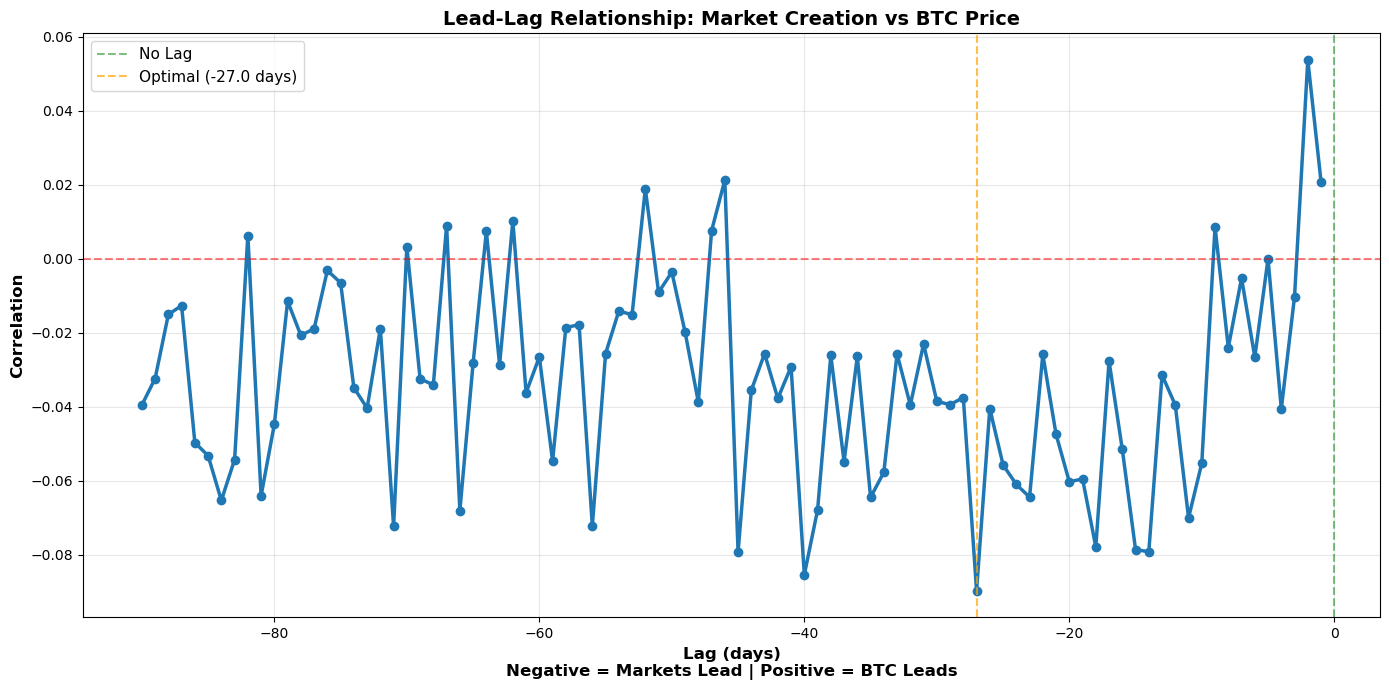

In [22]:
from scipy.stats import pearsonr
import numpy as np

# ============================================================================
# 1. GRANGER CAUSALITY TEST
# ============================================================================

print("\n" + "="*80)
print("CAUSALITY ANALYSIS")
print("="*80)

# Prepare daily data
daily_for_causality = pd.merge(
    daily_markets[['date', 'num_markets']],
    btc_daily_simple[['date', 'btc_price', 'btc_pct_change']],
    on='date',
    how='inner'
).sort_values('date')

# Remove zeros
daily_for_causality = daily_for_causality[daily_for_causality['num_markets'] > 0]

# Test different lags
max_lag = 90
lag_results = []

for lag in range(-max_lag, 0):
    df_temp = daily_for_causality.copy()
    
    if lag != 0:
        df_temp['markets_lagged'] = df_temp['num_markets'].shift(lag)
        clean = df_temp[['markets_lagged', 'btc_pct_change']].dropna()
        
        if len(clean) > 10:
            corr, pval = pearsonr(clean['markets_lagged'], clean['btc_pct_change'])
            lag_results.append({
                'lag': lag,
                'correlation': corr,
                'pvalue': pval
            })

if lag_results:
    lag_df = pd.DataFrame(lag_results)
    optimal = lag_df.loc[lag_df['correlation'].abs().idxmax()]
    
    print(f"Optimal lag: {optimal['lag']} days")
    print(f"Correlation: {optimal['correlation']:.4f}")
    print(f"P-value: {optimal['pvalue']:.4f}")
    
    if optimal['lag'] < 0:
        print(f"\n→ Market creation LEADS BTC price by {abs(optimal['lag'])} days")
        print(f"   (More markets created → BTC price moves later)")
    elif optimal['lag'] > 0:
        print(f"\n→ BTC price LEADS market creation by {optimal['lag']} days")
        print(f"   (BTC price moves → More markets created later)")
    else:
        print(f"\n→ SIMULTANEOUS movement")
    
    # Plot lag correlation
    plt.figure(figsize=(14, 7))
    
    plt.plot(lag_df['lag'], lag_df['correlation'],
             marker='o', linewidth=2.5, markersize=6)
    plt.axhline(0, color='red', linestyle='--', alpha=0.5)
    plt.axvline(0, color='green', linestyle='--', alpha=0.5, label='No Lag')
    plt.axvline(optimal['lag'], color='orange', linestyle='--', alpha=0.7,
               label=f'Optimal ({optimal["lag"]} days)')
    
    plt.xlabel('Lag (days)\nNegative = Markets Lead | Positive = BTC Leads',
              fontsize=12, fontweight='bold')
    plt.ylabel('Correlation', fontsize=12, fontweight='bold')
    plt.title('Lead-Lag Relationship: Market Creation vs BTC Price',
             fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lead_lag_analysis.png', dpi=300)
    plt.show()


MARKET CREATION SPIKES
Spike days: 56
Normal days: 598

Avg BTC price on spike days: $75,482
Avg BTC price on normal days: $74,704

Top 10 spike days:
      date  num_markets     btc_price  btc_pct_change
2025-11-12          172 101682.126653       -1.254952
2024-03-01          161  62524.401817        1.839928
2025-10-10          149 113754.852328       -6.454166
2025-11-25          144  87434.550611       -1.067071
2024-10-28          108  69862.520547        2.738778
2025-11-17           94  91911.471347       -3.799241
2025-10-06           88 124824.453667        2.024000
2025-04-14           83  84589.032414        1.474489
2025-09-16           77 116798.867051        1.193835
2025-05-09           75 102940.802949       -0.124902


Example markets created on spike days:
      date                                                                    question       volume
2024-09-16                Will the Democratic candidate win Pennsylvania by 1.5%-2.0%? 1.090638e+08
2024-01-08   

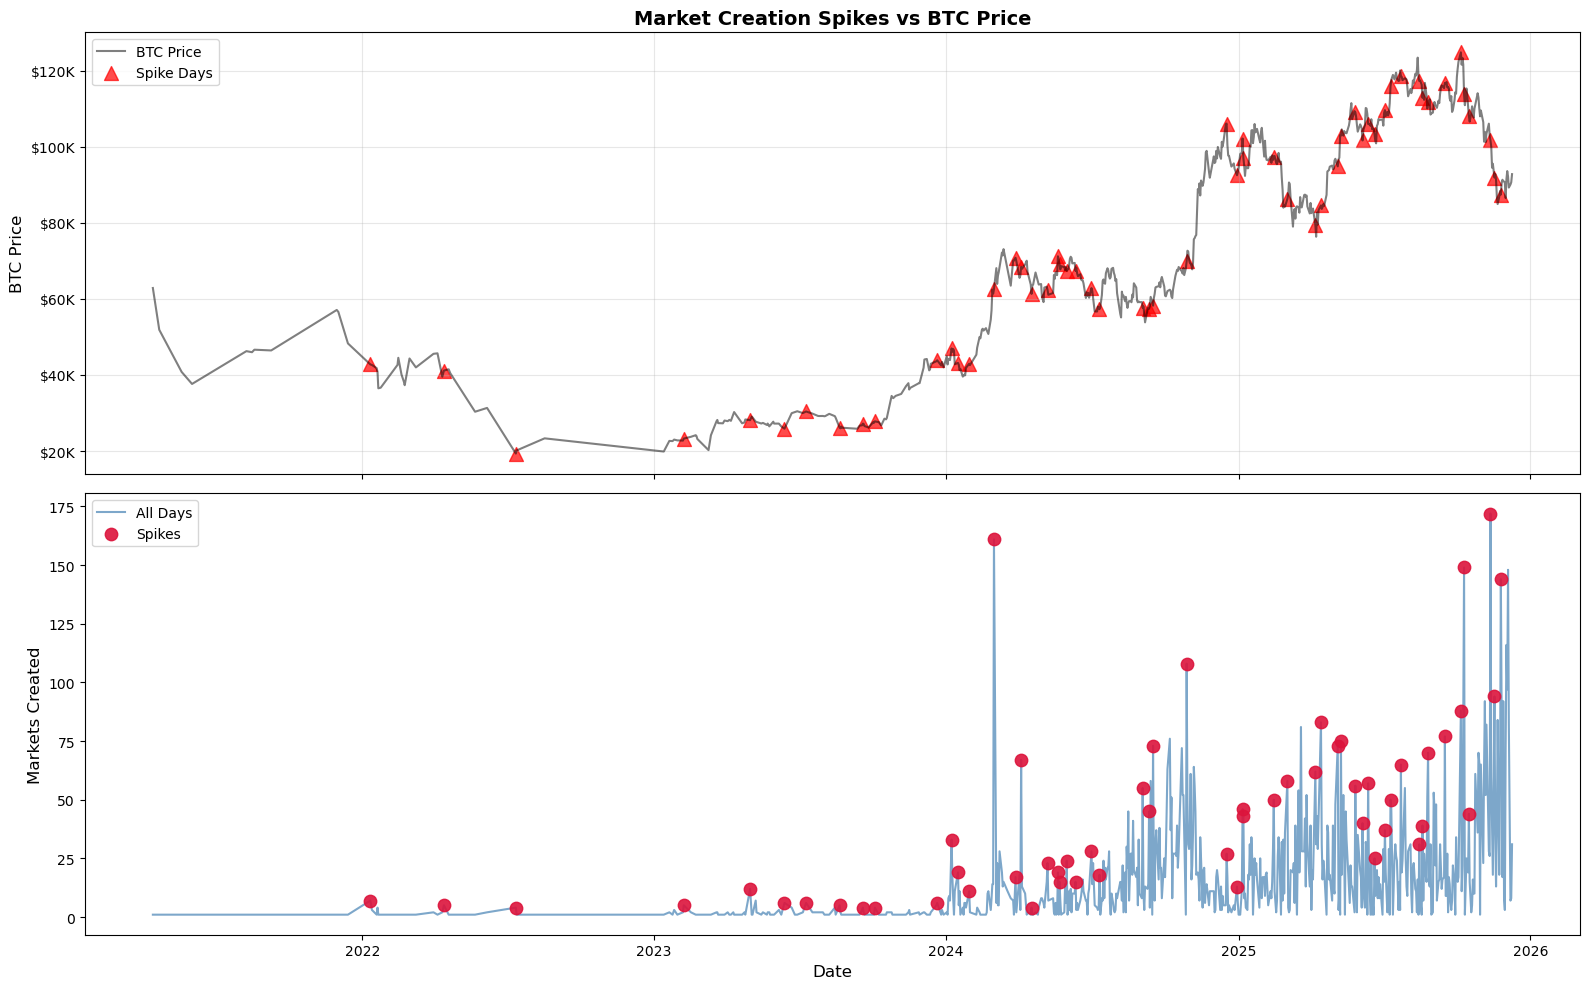

In [23]:
# ============================================================================
# 2. MARKET CREATION SPIKES
# ============================================================================

# Calculate 7-day moving average
daily_sorted = daily_markets.sort_values('date').copy()
daily_sorted['market_rolling_avg'] = (
    daily_sorted['num_markets'].rolling(window=7, center=True).mean()
)

# Define spike as >2x average
daily_sorted['is_spike'] = (
    daily_sorted['num_markets'] > 2 * daily_sorted['market_rolling_avg']
)

spike_days = daily_sorted[daily_sorted['is_spike']].copy()
normal_days = daily_sorted[~daily_sorted['is_spike']].copy()

print("\n" + "="*80)
print("MARKET CREATION SPIKES")
print("="*80)
print(f"Spike days: {len(spike_days)}")
print(f"Normal days: {len(normal_days)}")

if len(spike_days) > 5:
    print(f"\nAvg BTC price on spike days: ${spike_days['btc_price'].mean():,.0f}")
    print(f"Avg BTC price on normal days: ${normal_days['btc_price'].mean():,.0f}")
    
    print(f"\nTop 10 spike days:")
    spike_top = spike_days.nlargest(10, 'num_markets')[
        ['date', 'num_markets', 'btc_price', 'btc_pct_change']
    ]
    print(spike_top.to_string(index=False))
    
    # Merge with market data to see which markets
    spike_markets = pd.merge(
        spike_days[['date']],
        poly_market_btc[['created_date', 'question', 'volume']],
        left_on='date',
        right_on='created_date',
        how='left'
    )
    
    print(f"\n\nExample markets created on spike days:")
    print(spike_markets.nlargest(10, 'volume')[['date', 'question', 'volume']].to_string(index=False))
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # BTC Price with spike markers
    ax1.plot(pd.to_datetime(daily_sorted['date']), daily_sorted['btc_price'],
             color='black', linewidth=1.5, alpha=0.5, label='BTC Price')
    ax1.scatter(pd.to_datetime(spike_days['date']), spike_days['btc_price'],
               color='red', s=100, alpha=0.7, marker='^', label='Spike Days')
    ax1.set_ylabel('BTC Price', fontsize=12)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_title('Market Creation Spikes vs BTC Price', fontsize=14, fontweight='bold')
    
    # Market creation with spikes highlighted
    ax2.plot(pd.to_datetime(daily_sorted['date']), daily_sorted['num_markets'],
         color='steelblue', linewidth=1.5, alpha=0.7, label='All Days')
    ax2.scatter(pd.to_datetime(spike_days['date']), spike_days['num_markets'],
           color='crimson', s=80, alpha=0.9, marker='o', label='Spikes', zorder=5)
    ax2.set_ylabel('Markets Created', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend()
    
    
    plt.tight_layout()
    plt.savefig('market_creation_spikes.png', dpi=300)
    plt.show()

/var/folders/hn/pyg79cw15ql332wmddc7h_6c0000gn/T/ipykernel_41962/718985946.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_analysis = poly_market_btc.groupby('btc_bucket').agg({



MARKET CREATION BY BTC PRICE RANGE
BTC Price Range  Num Markets   Avg Volume  Avg BTC Price
          <$50K          418 1.183226e+07   37075.018502
      $50K-$75K         3202 7.708307e+05   64137.486382
     $75K-$100K         3709 5.054662e+05   89048.573296
    $100K-$150K         4274 3.290295e+05  110101.112460
         >$150K            0          NaN            NaN


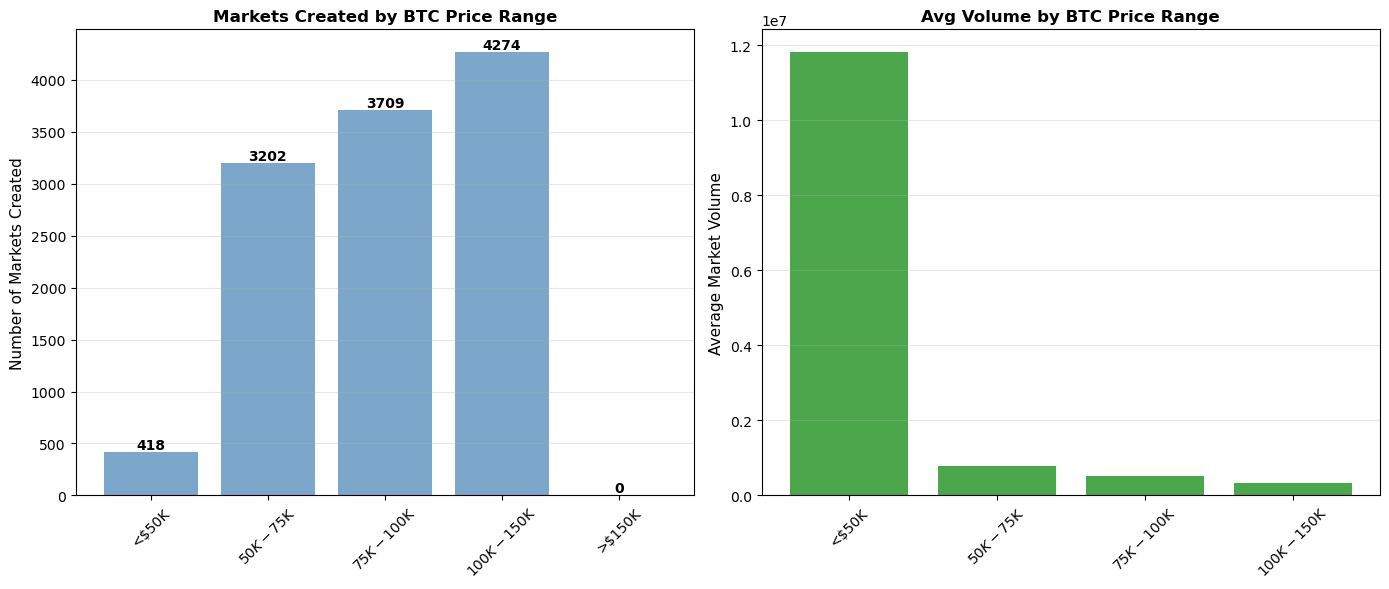

In [25]:
# ============================================================================
# 3. MARKET CREATION BY BTC PRICE RANGE
# ============================================================================

# Create BTC price buckets
poly_market_btc['btc_bucket'] = pd.cut(
    poly_market_btc['btc_price'],
    bins=[0, 50000, 75000, 100000, 150000, 1000000],
    labels=['<$50K', '$50K-$75K', '$75K-$100K', '$100K-$150K', '>$150K']
)

bucket_analysis = poly_market_btc.groupby('btc_bucket').agg({
    'market_id': 'count',
    'volume': 'mean',
    'btc_price': 'mean'
}).reset_index()

bucket_analysis.columns = ['BTC Price Range', 'Num Markets', 
                          'Avg Volume', 'Avg BTC Price']

print("\n" + "="*80)
print("MARKET CREATION BY BTC PRICE RANGE")
print("="*80)
print(bucket_analysis.to_string(index=False))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Number of markets by bucket
axes[0].bar(bucket_analysis['BTC Price Range'], 
           bucket_analysis['Num Markets'],
           color='steelblue', alpha=0.7)
axes[0].set_ylabel('Number of Markets Created', fontsize=11)
axes[0].set_title('Markets Created by BTC Price Range', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(bucket_analysis.iterrows()):
    axes[0].text(i, row['Num Markets'], f"{row['Num Markets']:.0f}",
                ha='center', va='bottom', fontweight='bold')

# Average volume by bucket
axes[1].bar(bucket_analysis['BTC Price Range'], 
           bucket_analysis['Avg Volume'],
           color='green', alpha=0.7)
axes[1].set_ylabel('Average Market Volume', fontsize=11)
axes[1].set_title('Avg Volume by BTC Price Range', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('btc_bucket_analysis.png', dpi=300)
plt.show()


YEARLY ANALYSIS
 Year  Num Markets  Total Volume  Avg BTC Price
 2021           12  5.612005e+05   49880.063607
 2022           45  2.308201e+06   38039.442890
 2023          191  5.164505e+07   30053.906240
 2024         3938  8.265094e+09   66826.307596
 2025         7417  2.375524e+09  101187.309025


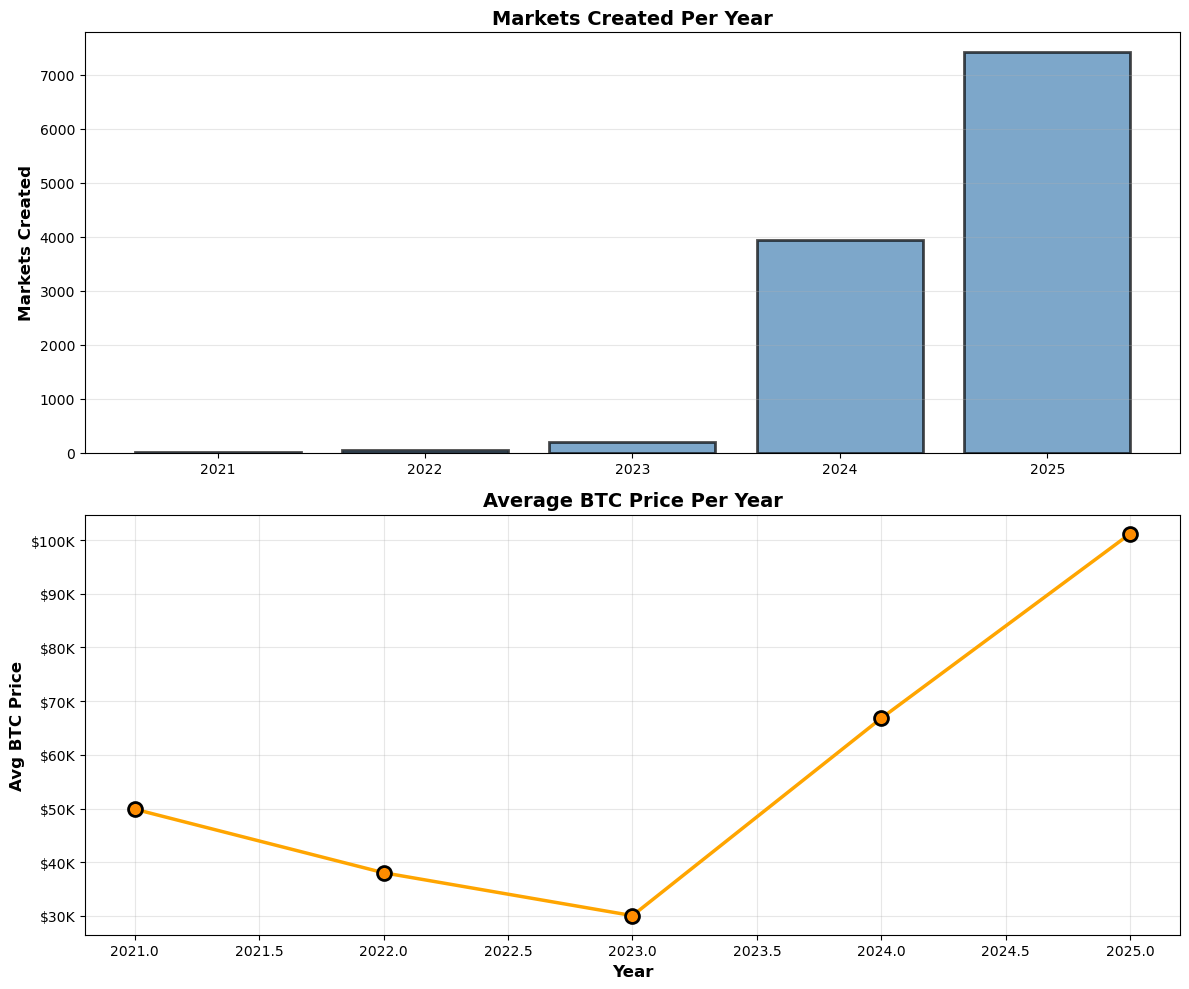


QUARTERLY ANALYSIS
Quarter  Num Markets  Total Volume  Avg BTC Price
 2021Q2            5  3.789953e+05   50248.435155
 2021Q3            4  1.594617e+05   46336.499674
 2021Q4            3  2.274351e+04   53990.862938
 2022Q1           26  1.414916e+06   41747.507223
 2022Q2           13  6.582403e+05   38883.942432
 2022Q3            6  2.350453e+05   20141.415111
 2023Q1           29  8.819557e+06   24111.694114
 2023Q2           61  8.477414e+06   27846.440517
 2023Q3           47  2.645434e+07   28098.469942
 2023Q4           54  7.893739e+06   37440.666737
 2024Q1          562  5.223139e+09   57918.131856
 2024Q2          479  3.921653e+08   66206.697713
 2024Q3         1224  9.255880e+08   61003.066429
 2024Q4         1673  1.724202e+09   74256.573638
 2025Q1         1431  7.470749e+08   92439.373302
 2025Q2         1595  8.217431e+08   96808.060984
 2025Q3         1608  7.327371e+08  114326.975890
 2025Q4         2783  7.396854e+07  100603.267462


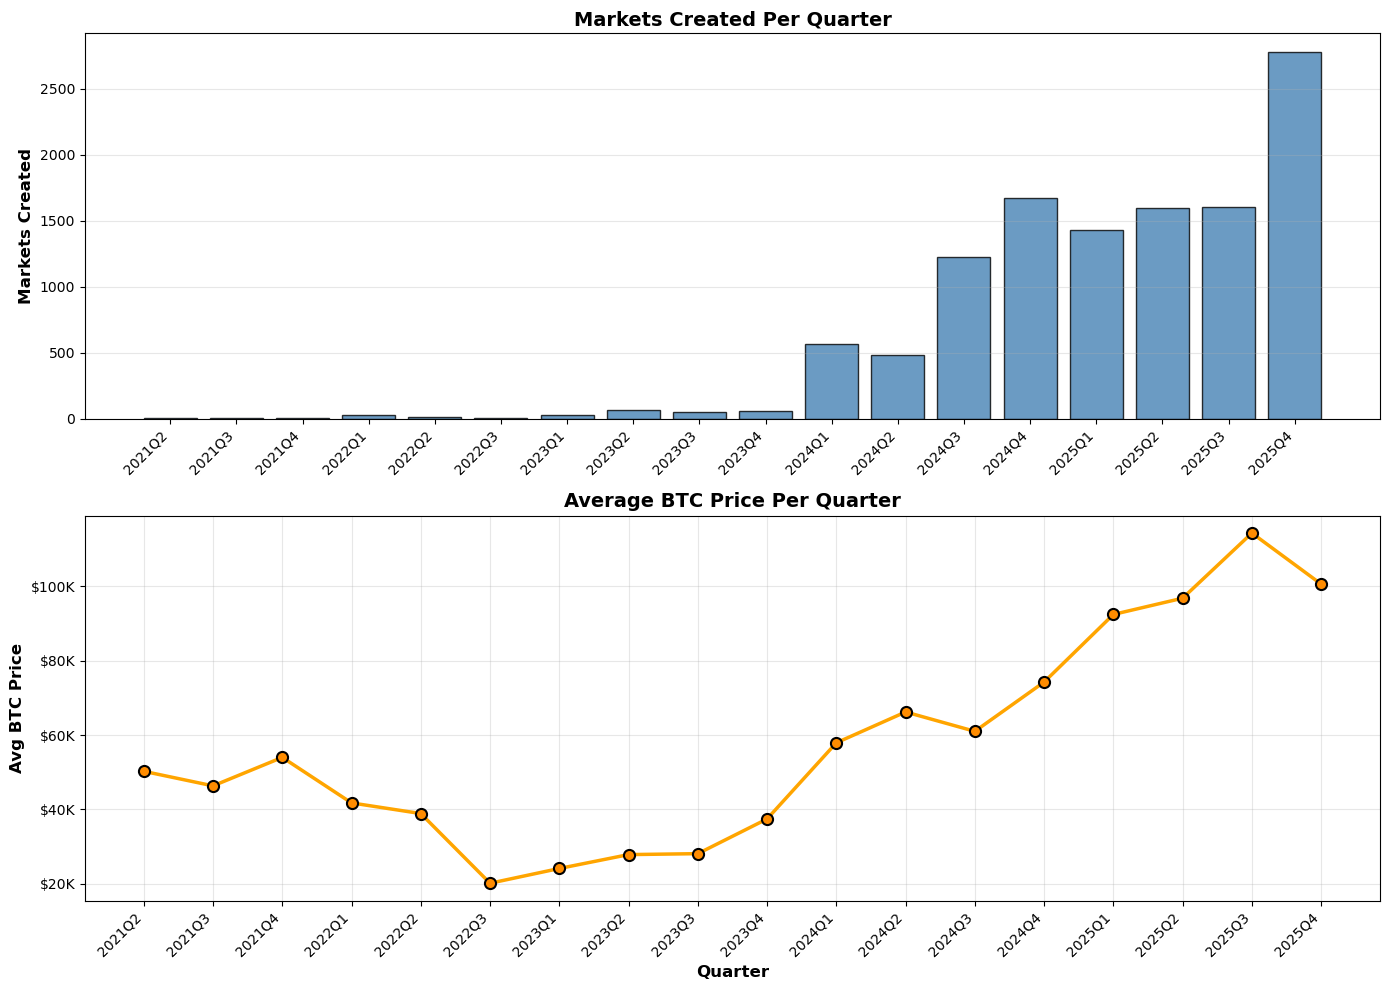

In [26]:
# ============================================================================
# 4. YEARLY/QUARTERLY BREAKDOWN
# ============================================================================

# Add time periods
poly_market_btc['year'] = pd.to_datetime(poly_market_btc['created_at']).dt.year
poly_market_btc['quarter'] = pd.to_datetime(poly_market_btc['created_at']).dt.to_period('Q')

# Yearly analysis
yearly = poly_market_btc.groupby('year').agg({
    'market_id': 'count',
    'volume': 'sum',
    'btc_price': 'mean'
}).reset_index()

yearly.columns = ['Year', 'Num Markets', 'Total Volume', 'Avg BTC Price']

print("\n" + "="*80)
print("YEARLY ANALYSIS")
print("="*80)
print(yearly.to_string(index=False))

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Markets per year
axes[0].bar(yearly['Year'], yearly['Num Markets'],
           color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Markets Created', fontsize=12, fontweight='bold')
axes[0].set_title('Markets Created Per Year', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# BTC price per year
axes[1].plot(yearly['Year'], yearly['Avg BTC Price'],
            marker='o', linewidth=2.5, markersize=10, color='orange',
            markerfacecolor='darkorange', markeredgecolor='black', markeredgewidth=2)
axes[1].set_ylabel('Avg BTC Price', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_title('Average BTC Price Per Year', fontsize=14, fontweight='bold')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('yearly_analysis.png', dpi=300)
plt.show()

# Quarterly analysis
quarterly = poly_market_btc.groupby('quarter').agg({
    'market_id': 'count',
    'volume': 'sum',
    'btc_price': 'mean'
}).reset_index()
quarterly.columns = ['Quarter', 'Num Markets', 'Total Volume', 'Avg BTC Price']

# Convert quarter back to string for display
quarterly['Quarter'] = quarterly['Quarter'].astype(str)

print("\n" + "="*80)
print("QUARTERLY ANALYSIS")
print("="*80)
print(quarterly.to_string(index=False))

# Plot quarterly
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Markets per quarter
axes[0].bar(range(len(quarterly)), quarterly['Num Markets'],
           color='steelblue', alpha=0.8, edgecolor='black', linewidth=1)
axes[0].set_xticks(range(len(quarterly)))
axes[0].set_xticklabels(quarterly['Quarter'], rotation=45, ha='right')
axes[0].set_ylabel('Markets Created', fontsize=12, fontweight='bold')
axes[0].set_title('Markets Created Per Quarter', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# BTC price per quarter
axes[1].plot(range(len(quarterly)), quarterly['Avg BTC Price'],
            marker='o', linewidth=2.5, markersize=8, color='orange',
            markerfacecolor='darkorange', markeredgecolor='black', markeredgewidth=1.5)
axes[1].set_xticks(range(len(quarterly)))
axes[1].set_xticklabels(quarterly['Quarter'], rotation=45, ha='right')
axes[1].set_ylabel('Avg BTC Price', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Quarter', fontsize=12, fontweight='bold')
axes[1].set_title('Average BTC Price Per Quarter', fontsize=14, fontweight='bold')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('quarterly_analysis.png', dpi=300)
plt.show()

In [28]:
# ============================================================================
# 7. BTC PRICE THRESHOLD ANALYSIS
# ============================================================================

# Compare market activity above/below different BTC price thresholds
thresholds = [25000, 50000, 75000, 100000]

threshold_results = []

for threshold in thresholds:
    above = poly_market_btc[poly_market_btc['btc_price'] > threshold]
    below = poly_market_btc[poly_market_btc['btc_price'] <= threshold]
    
    threshold_results.append({
        'Threshold': f'${threshold/1000:.0f}K',
        'Markets Above': len(above),
        'Avg Volume Above': above['volume'].mean(),
        'Markets Below': len(below),
        'Avg Volume Below': below['volume'].mean(),
        'Ratio (Above/Below)': len(above) / max(len(below), 1)
    })

threshold_df = pd.DataFrame(threshold_results)

print("\n" + "="*80)
print("THRESHOLD ANALYSIS")
print("="*80)
print(threshold_df.round(2).to_string(index=False))

# Interpretation
print("\n\nInterpretation:")
for idx, row in threshold_df.iterrows():
    if row['Ratio (Above/Below)'] > 1.2:
        print(f"  → MORE markets created when BTC > {row['Threshold']}")
    elif row['Ratio (Above/Below)'] < 0.8:
        print(f"  → FEWER markets created when BTC > {row['Threshold']}")
    else:
        print(f"  → SIMILAR market creation above/below {row['Threshold']}")


THRESHOLD ANALYSIS
Threshold  Markets Above  Avg Volume Above  Markets Below  Avg Volume Below  Ratio (Above/Below)
     $25K          11575         923233.63             28         310824.53               413.39
     $50K          11185         514013.96            418       11832263.71                26.76
     $75K           7983         411004.17           3620        2048090.09                 2.21
    $100K           4274         329029.53           7329        1267411.68                 0.58


Interpretation:
  → MORE markets created when BTC > $25K
  → MORE markets created when BTC > $50K
  → MORE markets created when BTC > $75K
  → FEWER markets created when BTC > $100K


In [86]:
display(poly_tokens_politics_clean)

,market_id,token_id,outcome,question
176,240584,3947506494278365205368124689314753252429356373...,Yes,Will Valerie Pecresse win the 2022 French pres...
177,240584,5480256031258914272992158751092692872415626042...,No,Will Valerie Pecresse win the 2022 French pres...
178,240585,6573979316199210406752160392925785635050728828...,Yes,Will Marine Le Pen win the 2022 French preside...
179,240585,7502204389681087970191750614658257994613608356...,No,Will Marine Le Pen win the 2022 French preside...
180,240586,8923537341582753820147490806696122485377828323...,Yes,Will Eric Zemmour win the 2022 French presiden...
...,...,...,...,...
156241,546471,2951804949752556684718002886863045466219610283...,No,Will Siaosi Pōhiva be the next Prime Minister ...
156342,647130,1128619987238474361624505653836002273782742354...,Yes,"Will Reddit say ""Election"" during earnings call?"
156343,647130,6574503765138757589285792212666135796745670688...,No,"Will Reddit say ""Election"" during earnings call?"
156406,647475,8323473105963719224529843098951742049294706270...,Yes,"Will anyone say ""Trump"" during the FED board m..."


In [93]:
trade_token_merge = pd.merge(poly_trades_politics_clean, poly_tokens_politics_clean[['token_id', 'outcome']], on = 'token_id', how = 'left')
trade_token_merge

,market_id,token_id,timestamp,price,size,side,question,trade_date,outcome
0,523605,9950717231029230406165947094925029043862287145...,2025-04-07 18:28:15,0.015,14.000000,SELL,Will Lee Zeldin be out as Administrator of the...,2025-04-07,Yes
1,523605,9950717231029230406165947094925029043862287145...,2025-04-07 18:28:17,0.015,14.000000,SELL,Will Lee Zeldin be out as Administrator of the...,2025-04-07,Yes
2,523605,9950717231029230406165947094925029043862287145...,2025-04-07 18:28:19,0.015,14.000000,SELL,Will Lee Zeldin be out as Administrator of the...,2025-04-07,Yes
3,523605,9950717231029230406165947094925029043862287145...,2025-04-07 18:28:19,0.015,14.000000,SELL,Will Lee Zeldin be out as Administrator of the...,2025-04-07,Yes
4,523605,9950717231029230406165947094925029043862287145...,2025-04-07 18:28:29,0.015,14.000000,SELL,Will Lee Zeldin be out as Administrator of the...,2025-04-07,Yes
...,...,...,...,...,...,...,...,...,...
2648590,561985,2652814724933719576712958625055698322914303600...,2026-01-05 06:25:19,0.992,5.413250,BUY,Will Brian Kemp win the 2028 Republican presid...,2026-01-05,No
2648591,562004,3337233094702386052587063075854913790217057691...,2026-01-05 06:25:19,0.990,23.151500,BUY,Will Marjorie Taylor Greene win the 2028 Repub...,2026-01-05,No
2648592,561973,2782897664868246677877699907621542377776697298...,2026-01-05 06:25:19,0.961,25.005179,BUY,Will Donald Trump win the 2028 Republican pres...,2026-01-05,No
2648593,561991,8409529381329385248635760260604838650759146033...,2026-01-05 06:25:19,0.995,25.005000,BUY,Will Matt Gaetz win the 2028 Republican presid...,2026-01-05,No


In [111]:
trade_token_merge['dollar_value'] = trade_token_merge['price']* trade_token_merge['size']
trade_token_merge_btc = pd.merge(
    trade_token_merge,
    btc_daily_simple,
    left_on='trade_date',
    right_on='date',
    how='left'
)

trade_token_merge_btc_clean = trade_token_merge_btc[
    trade_token_merge_btc['outcome'].isin(['Yes', 'No'])
].copy()

daily_buysell = trade_token_merge_btc_clean.groupby(['side', 'question', 'outcome']).agg({
    'dollar_value': 'sum',
    'size': 'sum',
    'token_id': 'nunique',
    'btc_price': 'mean'
}).reset_index()

daily_buysell['side_outcome'] = daily_buysell['side'] + '_' + daily_buysell['outcome']

buysell_pivot = daily_buysell.pivot(
    index='question',
    columns='side_outcome',
    values='dollar_value'
).fillna(0).reset_index()

buysell_pivot['NET_No'] = buysell_pivot['BUY_No'] - buysell_pivot['SELL_No']
buysell_pivot['NET_Yes'] = buysell_pivot['BUY_Yes'] - buysell_pivot['SELL_Yes']
btc_by_question = daily_buysell.groupby('question')['btc_price'].mean().reset_index()

buysell_pivot = pd.merge(
    buysell_pivot,
    btc_by_question,
    on='question',
    how='left'
)
buysell_pivot


,question,BUY_No,BUY_Yes,SELL_No,SELL_Yes,NET_No,NET_Yes,btc_price
0,Elon Musk out as Senior Advisor to Trump in May?,0.000000,37893.347983,0.000000,25808.899297,0.000000,12084.448686,104512.254876
1,Karen Bass recall election called before Sept...,7679.174753,79.998103,2272.633406,162.262759,5406.541347,-82.264656,101443.090220
2,Will Trump publicly disparage Netanyahu befor...,0.000000,3505.255608,0.000000,1716.686872,0.000000,1788.568736,105414.828043
3,"2026 Balance of Power: D Senate, D House",11238.947332,14868.269073,1351.250900,371.244000,9887.696432,14497.025073,91245.321266
4,"2026 Balance of Power: D Senate, R House",8561.510955,274.686662,1539.287240,27.499760,7022.223715,247.186902,91083.818506
...,...,...,...,...,...,...,...,...
4238,Zelenskyy out as Ukraine president by March 31...,28221.145560,4078.565398,1738.161700,127.953870,26482.983860,3950.611528,90004.852880
4239,Zelenskyy out as Ukraine president by end of 2...,42124.254830,28134.421785,5652.993200,2714.064200,36471.261630,25420.357585,90204.711922
4240,Zellnor Myrie gets the most first-choice votes...,2633.107589,0.000000,0.000000,0.000000,2633.107589,0.000000,105483.556673
4241,Zohran Mamdani gets the most first-choice vote...,453687.981182,0.000000,113386.649847,0.000000,340301.331335,0.000000,105884.738079


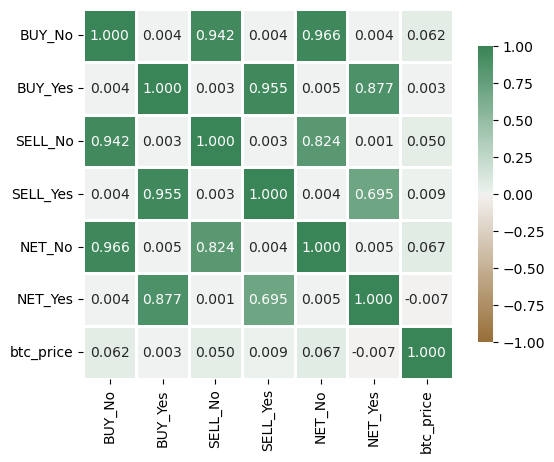

In [112]:
correlation_buysell_pivot = buysell_pivot[['BUY_No','BUY_Yes', 'SELL_No', 'SELL_Yes', 'NET_No', 'NET_Yes', 'btc_price']].corr()

axis_corr = sns.heatmap(
correlation_buysell_pivot,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(50, 500, n=500),
square=True,
annot=True,
fmt='.3f',               
linewidths=2,            
cbar_kws={"shrink": 0.8} 
)

plt.show()


Daily data points: 256

DAILY CORRELATIONS (TIME-SERIES)
YES Net Flow vs BTC Change: 0.0249 (p=0.6920)
NO Net Flow vs BTC Change:  0.0899 (p=0.1517)


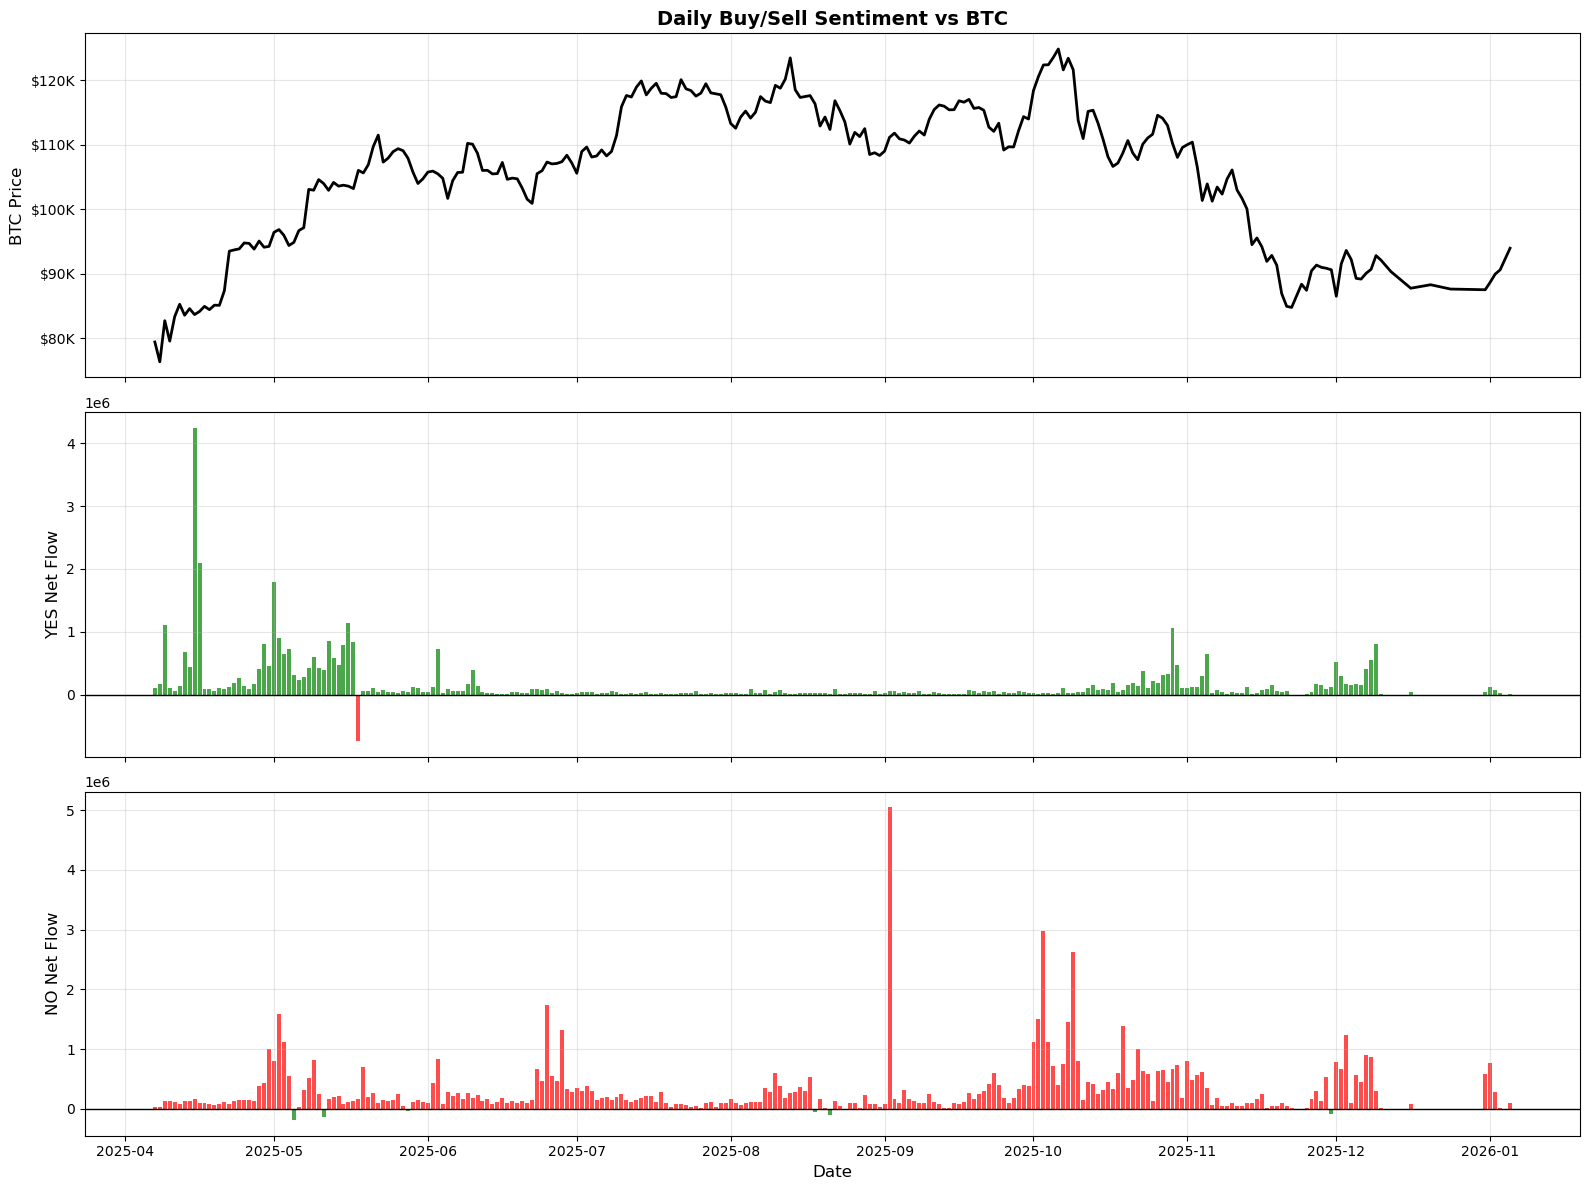


✓ Daily time-series analysis complete!


In [116]:
# ============================================================================
# CORRECT APPROACH: DAILY TIME-SERIES
# ============================================================================

# Daily aggregation by side and outcome
daily_buysell_time = trade_token_merge_btc.groupby(['trade_date', 'side', 'outcome']).agg({
    'dollar_value': 'sum'
}).reset_index()

# Create side_outcome
daily_buysell_time['side_outcome'] = (
    daily_buysell_time['side'] + '_' + daily_buysell_time['outcome']
)

# Pivot
daily_pivot = daily_buysell_time.pivot(
    index='trade_date',
    columns='side_outcome',
    values='dollar_value'
).fillna(0).reset_index()

# Merge with BTC daily data
daily_pivot = pd.merge(
    daily_pivot,
    btc_daily_simple[['date', 'btc_price', 'btc_pct_change']],
    left_on='trade_date',
    right_on='date',
    how='left'
).dropna()

# Calculate metrics
if 'BUY_Yes' in daily_pivot.columns and 'BUY_No' in daily_pivot.columns:
    daily_pivot['NET_Yes'] = daily_pivot.get('BUY_Yes', 0) - daily_pivot.get('SELL_Yes', 0)
    daily_pivot['NET_No'] = daily_pivot.get('BUY_No', 0) - daily_pivot.get('SELL_No', 0)
    daily_pivot['NET'] = daily_pivot['NET_Yes'] + daily_pivot['NET_No']

# Remove zero-activity days
daily_pivot = daily_pivot[
    (daily_pivot.get('BUY_Yes', 0) + daily_pivot.get('BUY_No', 0) + 
     daily_pivot.get('SELL_Yes', 0) + daily_pivot.get('SELL_No', 0)) > 0
]

print(f"\nDaily data points: {len(daily_pivot)}")

# CALCULATE CORRELATIONS
print("\n" + "="*80)
print("DAILY CORRELATIONS (TIME-SERIES)")
print("="*80)

correlations_daily = []

if len(daily_pivot) > 10:
    # YES_NET vs BTC change
    if 'NET_Yes' in daily_pivot.columns:
        corr, pval = pearsonr(daily_pivot['NET_Yes'], daily_pivot['btc_pct_change'])
        correlations_daily.append({
            'Metric': 'YES Net Flow',
            'vs': 'BTC % Change',
            'Correlation': f"{corr:.4f}",
            'P-value': f"{pval:.4f}"
        })
        print(f"YES Net Flow vs BTC Change: {corr:.4f} (p={pval:.4f})")
    
    # NO_NET vs BTC change
    if 'NET_No' in daily_pivot.columns:
        corr, pval = pearsonr(daily_pivot['NET_No'], daily_pivot['btc_pct_change'])
        correlations_daily.append({
            'Metric': 'NO Net Flow',
            'vs': 'BTC % Change',
            'Correlation': f"{corr:.4f}",
            'P-value': f"{pval:.4f}"
        })
        print(f"NO Net Flow vs BTC Change:  {corr:.4f} (p={pval:.4f})")
    
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    # BTC Price
    axes[0].plot(pd.to_datetime(daily_pivot['trade_date']), 
                daily_pivot['btc_price'],
                linewidth=2, color='black')
    axes[0].set_ylabel('BTC Price', fontsize=12)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    axes[0].grid(alpha=0.3)
    axes[0].set_title('Daily Buy/Sell Sentiment vs BTC', fontsize=14, fontweight='bold')
    
    # YES Net Flow
    if 'NET_Yes' in daily_pivot.columns:
        colors = ['green' if x > 0 else 'red' for x in daily_pivot['NET_Yes']]
        axes[1].bar(pd.to_datetime(daily_pivot['trade_date']), 
                   daily_pivot['NET_Yes'],
                   color=colors, alpha=0.7)
        axes[1].axhline(0, color='black', linewidth=1)
        axes[1].set_ylabel('YES Net Flow', fontsize=12)
        axes[1].grid(alpha=0.3)
    
    # NO Net Flow
    if 'NET_No' in daily_pivot.columns:
        colors = ['red' if x > 0 else 'green' for x in daily_pivot['NET_No']]
        axes[2].bar(pd.to_datetime(daily_pivot['trade_date']), 
                   daily_pivot['NET_No'],
                   color=colors, alpha=0.7)
        axes[2].axhline(0, color='black', linewidth=1)
        axes[2].set_ylabel('NO Net Flow', fontsize=12)
        axes[2].set_xlabel('Date', fontsize=12)
        axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('daily_sentiment_timeseries.png', dpi=300)
    plt.show()

print("\n✓ Daily time-series analysis complete!")

In [117]:
# ============================================================================
# ANALYZE CHANGES, NOT ABSOLUTE LEVELS
# ============================================================================

# Calculate day-over-day changes
daily_changes = daily_pivot.sort_values('trade_date').copy()

daily_changes['YES_NET_change'] = daily_changes.get('NET_Yes', 0).pct_change() * 100
daily_changes['NO_NET_change'] = daily_changes.get('NET_No', 0).pct_change() * 100

# Remove outliers and NaN
daily_changes = daily_changes[
    (abs(daily_changes.get('YES_NET_change', 0)) < 500) &
    (abs(daily_changes.get('NO_NET_change', 0)) < 500)
].dropna()

print("\n" + "="*80)
print("CHANGES CORRELATION")
print("="*80)

if len(daily_changes) > 10:
    # Correlate CHANGES
    if 'YES_NET_change' in daily_changes.columns:
        corr, pval = pearsonr(
            daily_changes['YES_NET_change'],
            daily_changes['btc_pct_change']
        )
        print(f"YES Net Flow CHANGE vs BTC Change: {corr:.4f} (p={pval:.4f})")
    
    if 'NO_NET_change' in daily_changes.columns:
        corr, pval = pearsonr(
            daily_changes['NO_NET_change'],
            daily_changes['btc_pct_change']
        )
        print(f"NO Net Flow CHANGE vs BTC Change:  {corr:.4f} (p={pval:.4f})")


CHANGES CORRELATION
YES Net Flow CHANGE vs BTC Change: 0.0309 (p=0.6374)
NO Net Flow CHANGE vs BTC Change:  0.2108 (p=0.0011)



SIGNIFICANT FINDING: NO TOKEN NET FLOW

KEY INSIGHT:
  • NO Net Flow CHANGE vs BTC Change: r=0.2108, p=0.0011 ✓ SIGNIFICANT
  • YES Net Flow CHANGE vs BTC Change: r=0.0309, p=0.6374 ✗ Not significant

INTERPRETATION:
  → Changes in NO token buying/selling ARE correlated with BTC price changes
  → When people buy more NO tokens (bearish bets), BTC tends to move
  → This is a STATISTICALLY SIGNIFICANT relationship

WHAT THIS MEANS:
  • NO tokens = Betting political events WON'T happen
  • Correlation = 0.21 is MODERATE strength
  • P-value = 0.001 is HIGHLY SIGNIFICANT (<<0.05)
  
  → Bearish political sentiment correlates with BTC movement


Sample size: 235 days

Statistics:
  NO Net Flow change range: [-475.98%, 401.33%]
  BTC change range: [-6.45%, 7.02%]


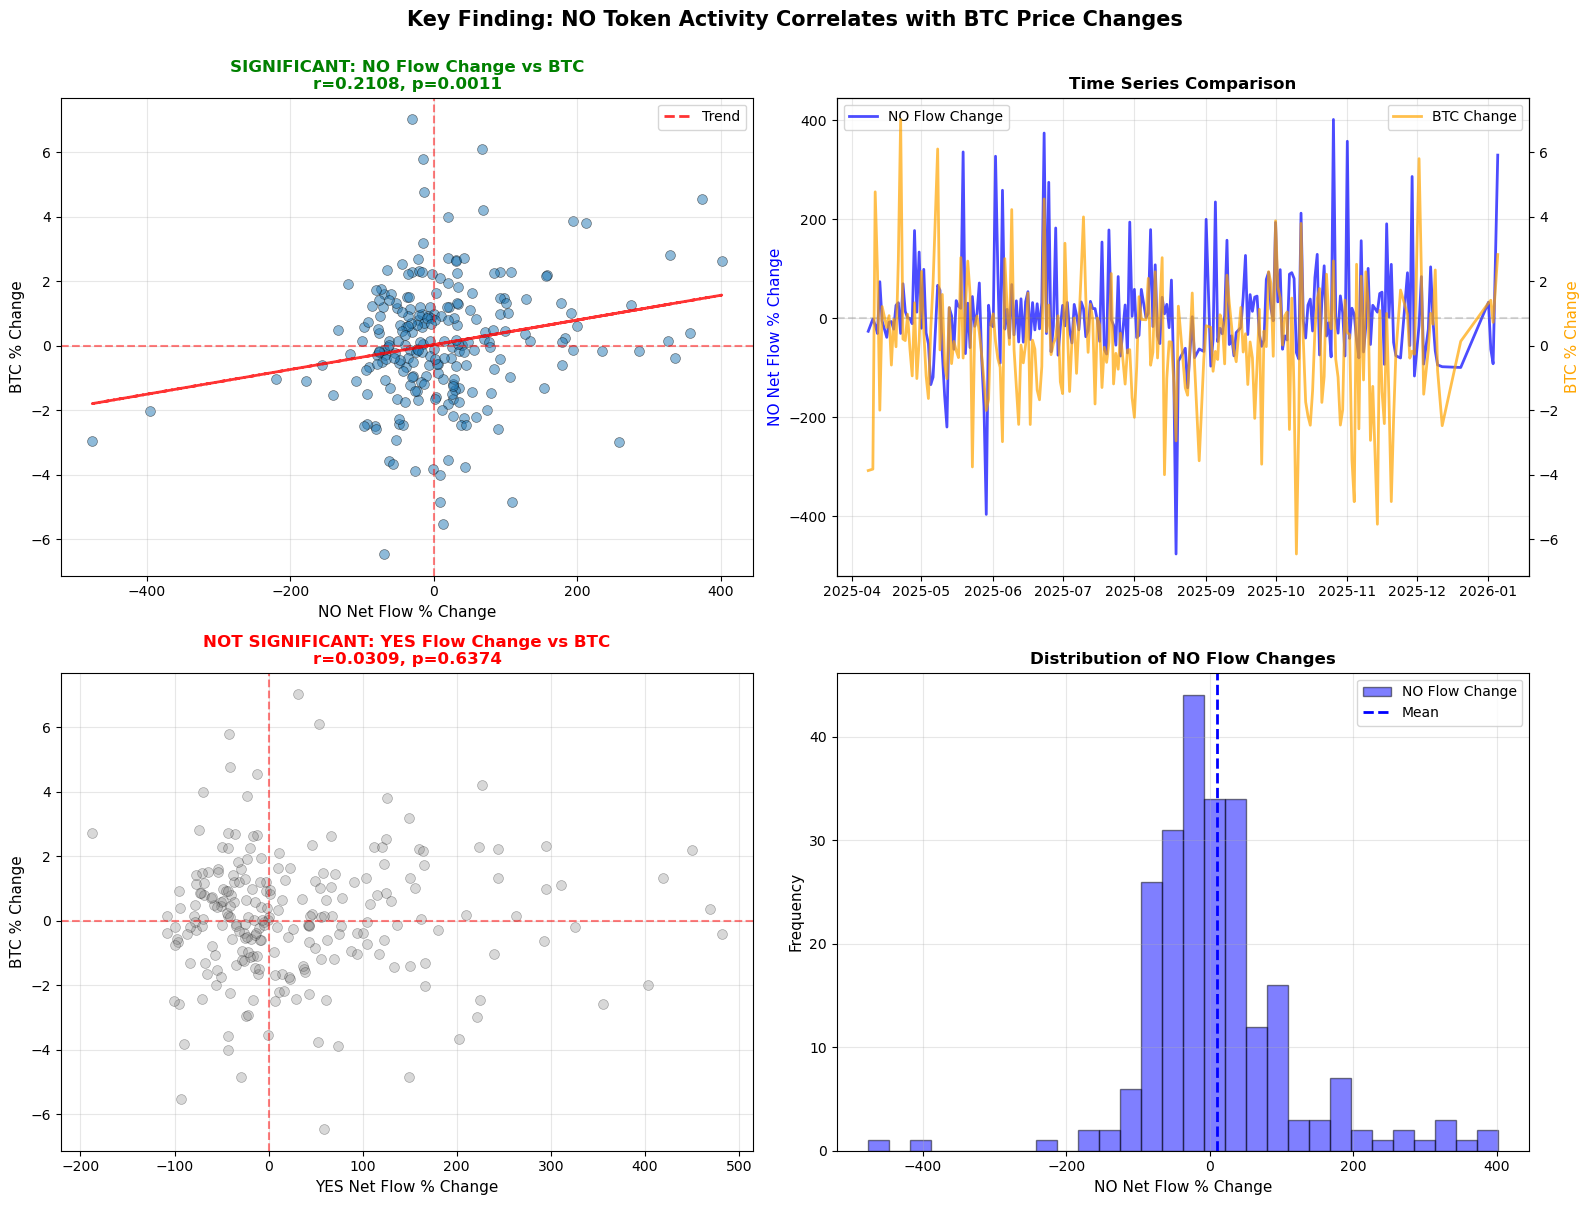


✓ Significant finding visualized!


In [119]:
print("\n" + "="*80)
print("SIGNIFICANT FINDING: NO TOKEN NET FLOW")
print("="*80)

print(f"""
KEY INSIGHT:
  • NO Net Flow CHANGE vs BTC Change: r=0.2108, p=0.0011 ✓ SIGNIFICANT
  • YES Net Flow CHANGE vs BTC Change: r=0.0309, p=0.6374 ✗ Not significant

INTERPRETATION:
  → Changes in NO token buying/selling ARE correlated with BTC price changes
  → When people buy more NO tokens (bearish bets), BTC tends to move
  → This is a STATISTICALLY SIGNIFICANT relationship

WHAT THIS MEANS:
  • NO tokens = Betting political events WON'T happen
  • Correlation = 0.21 is MODERATE strength
  • P-value = 0.001 is HIGHLY SIGNIFICANT (<<0.05)
  
  → Bearish political sentiment correlates with BTC movement
""")

# ============================================================================
# DEEPER ANALYSIS OF NO TOKEN BEHAVIOR
# ============================================================================

# Get the data we used for this correlation
no_flow_analysis = daily_changes[['trade_date', 'NO_NET_change', 'btc_pct_change']].dropna()

print(f"\nSample size: {len(no_flow_analysis)} days")
print(f"\nStatistics:")
print(f"  NO Net Flow change range: [{no_flow_analysis['NO_NET_change'].min():.2f}%, "
      f"{no_flow_analysis['NO_NET_change'].max():.2f}%]")
print(f"  BTC change range: [{no_flow_analysis['btc_pct_change'].min():.2f}%, "
      f"{no_flow_analysis['btc_pct_change'].max():.2f}%]")

# ============================================================================
# VISUALIZE THE SIGNIFICANT RELATIONSHIP
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot - NO Net Flow Change vs BTC Change
axes[0, 0].scatter(no_flow_analysis['NO_NET_change'], 
                  no_flow_analysis['btc_pct_change'],
                  alpha=0.5, s=50, edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('NO Net Flow % Change', fontsize=11)
axes[0, 0].set_ylabel('BTC % Change', fontsize=11)
axes[0, 0].set_title(f'SIGNIFICANT: NO Flow Change vs BTC\nr={0.2108:.4f}, p={0.0011:.4f}',
                    fontsize=12, fontweight='bold', color='green')
axes[0, 0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(no_flow_analysis['NO_NET_change'], no_flow_analysis['btc_pct_change'], 1)
p = np.poly1d(z)
axes[0, 0].plot(no_flow_analysis['NO_NET_change'], 
               p(no_flow_analysis['NO_NET_change']),
               "r--", alpha=0.8, linewidth=2, label='Trend')
axes[0, 0].legend()

# 2. Time series comparison
ax1 = axes[0, 1]
ax2 = ax1.twinx()

ax1.plot(pd.to_datetime(no_flow_analysis['trade_date']), 
        no_flow_analysis['NO_NET_change'],
        linewidth=2, color='blue', label='NO Flow Change', alpha=0.7)
ax2.plot(pd.to_datetime(no_flow_analysis['trade_date']), 
        no_flow_analysis['btc_pct_change'],
        linewidth=2, color='orange', label='BTC Change', alpha=0.7)

ax1.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax1.set_ylabel('NO Net Flow % Change', color='blue', fontsize=11)
ax2.set_ylabel('BTC % Change', color='orange', fontsize=11)
ax1.set_title('Time Series Comparison', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(alpha=0.3)

# 3. YES comparison (not significant)
yes_flow_analysis = daily_changes[['trade_date', 'YES_NET_change', 'btc_pct_change']].dropna()

axes[1, 0].scatter(yes_flow_analysis['YES_NET_change'], 
                  yes_flow_analysis['btc_pct_change'],
                  alpha=0.3, s=50, color='gray', edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('YES Net Flow % Change', fontsize=11)
axes[1, 0].set_ylabel('BTC % Change', fontsize=11)
axes[1, 0].set_title(f'NOT SIGNIFICANT: YES Flow Change vs BTC\nr={0.0309:.4f}, p={0.6374:.4f}',
                    fontsize=12, fontweight='bold', color='red')
axes[1, 0].grid(alpha=0.3)

# 4. Distribution comparison
axes[1, 1].hist(no_flow_analysis['NO_NET_change'], bins=30, 
               alpha=0.5, color='blue', label='NO Flow Change', edgecolor='black')
axes[1, 1].axvline(no_flow_analysis['NO_NET_change'].mean(), 
                  color='blue', linestyle='--', linewidth=2, label='Mean')
axes[1, 1].set_xlabel('NO Net Flow % Change', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of NO Flow Changes', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Key Finding: NO Token Activity Correlates with BTC Price Changes',
            fontsize=15, fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig('no_token_significance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Significant finding visualized!")

LEAD-LAG ANALYSIS: NO TOKEN FLOW vs BTC
Data points for lag analysis: 242

OPTIMAL LAG RESULTS
Optimal lag: 0.0 days
Correlation: 0.2310
P-value: 0.0003
Sample size: 242.0

INTERPRETATION
→ SIMULTANEOUS MOVEMENT (lag = 0)
  • NO token changes and BTC changes happen together
  • No clear lead-lag relationship


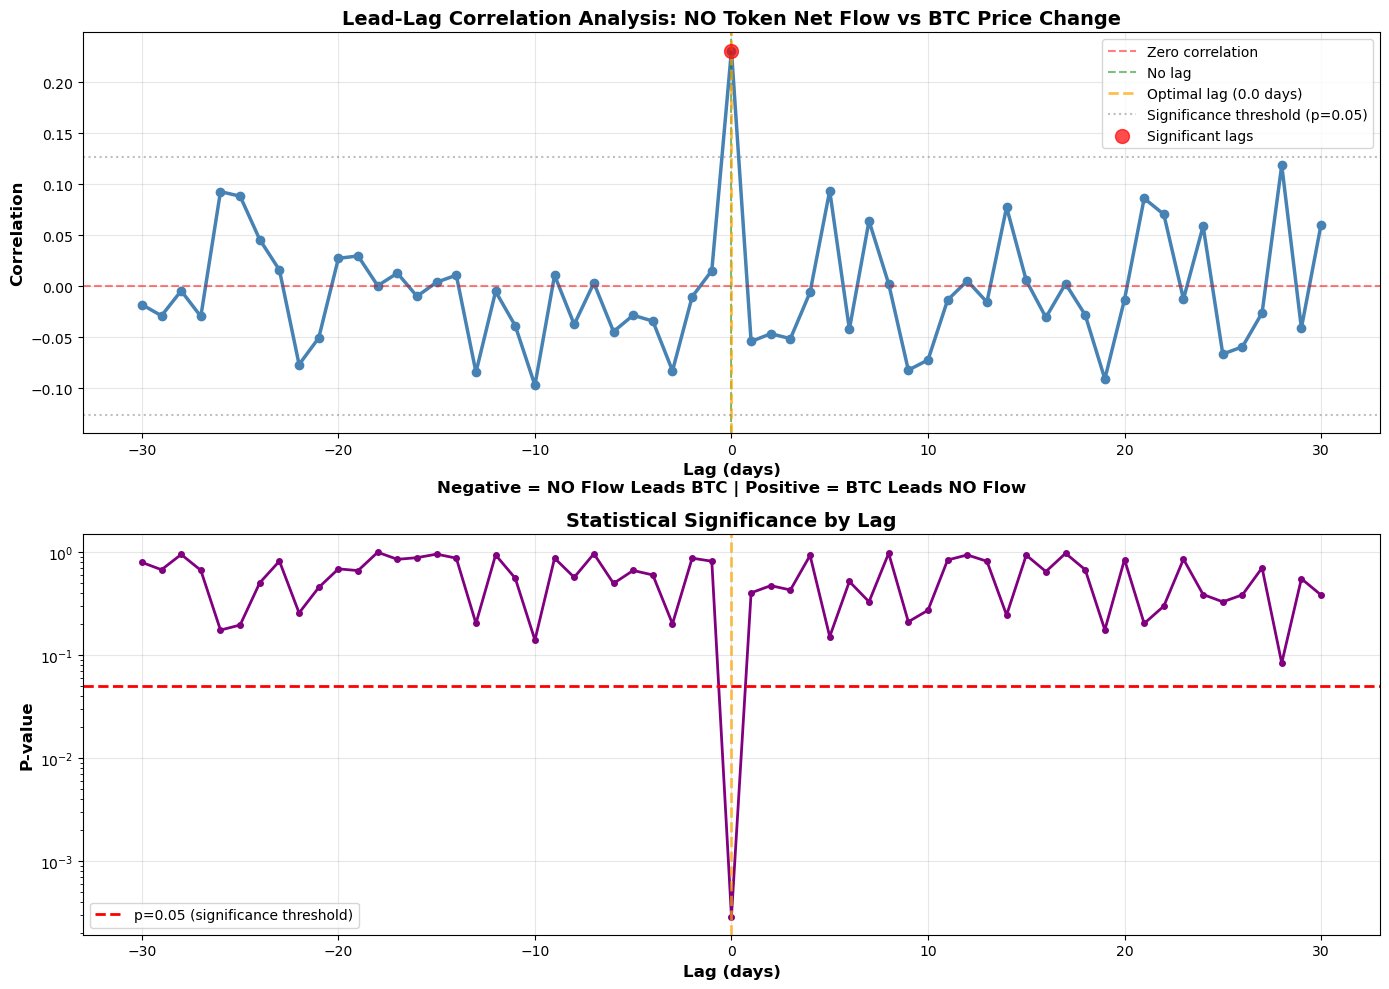


✓ Lead-lag analysis complete!


In [124]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# LEAD-LAG ANALYSIS (±30 days)
# ============================================================================

print("="*80)
print("LEAD-LAG ANALYSIS: NO TOKEN FLOW vs BTC")
print("="*80)

# Prepare data - make sure it's sorted by date
no_flow_timeseries = daily_pivot[['trade_date', 'NET_No', 'btc_pct_change']].sort_values('trade_date').copy()

# Calculate NO_NET change
no_flow_timeseries['NO_NET_change'] = no_flow_timeseries['NET_No'].pct_change() * 100

# Remove NaN and outliers
no_flow_timeseries = no_flow_timeseries[
    (no_flow_timeseries['NO_NET_change'].notna()) &
    (no_flow_timeseries['btc_pct_change'].notna()) &
    (abs(no_flow_timeseries['NO_NET_change']) < 500)
].copy()

print(f"Data points for lag analysis: {len(no_flow_timeseries)}")

# Test different lags
max_lag = 30
lag_results = []

for lag in range(-max_lag, max_lag + 1):
    df_temp = no_flow_timeseries.copy()
    
    if lag == 0:
        # No lag
        clean = df_temp[['NO_NET_change', 'btc_pct_change']].dropna()
        if len(clean) > 10:
            corr, pval = pearsonr(clean['NO_NET_change'], clean['btc_pct_change'])
    else:
        # Shift NO flow by lag days
        df_temp['NO_lagged'] = df_temp['NO_NET_change'].shift(lag)
        clean = df_temp[['NO_lagged', 'btc_pct_change']].dropna()
        
        if len(clean) > 10:
            corr, pval = pearsonr(clean['NO_lagged'], clean['btc_pct_change'])
    
    if len(clean) > 10:
        lag_results.append({
            'lag': lag,
            'correlation': corr,
            'pvalue': pval,
            'sample_size': len(clean)
        })

lag_df = pd.DataFrame(lag_results)

# Find optimal lag
optimal_lag = lag_df.loc[lag_df['correlation'].abs().idxmax()]

print("\n" + "="*80)
print("OPTIMAL LAG RESULTS")
print("="*80)
print(f"Optimal lag: {optimal_lag['lag']} days")
print(f"Correlation: {optimal_lag['correlation']:.4f}")
print(f"P-value: {optimal_lag['pvalue']:.4f}")
print(f"Sample size: {optimal_lag['sample_size']}")

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

if optimal_lag['lag'] < 0:
    print(f"→ NO TOKEN FLOW LEADS BTC by {abs(optimal_lag['lag'])} days")
    print(f"  • Changes in NO token buying happen FIRST")
    print(f"  • BTC price changes follow {abs(optimal_lag['lag'])} days later")
    print(f"  • NO token activity is a LEADING indicator")
elif optimal_lag['lag'] > 0:
    print(f"→ BTC PRICE LEADS NO TOKEN FLOW by {optimal_lag['lag']} days")
    print(f"  • BTC price changes happen FIRST")
    print(f"  • NO token buying changes follow {optimal_lag['lag']} days later")
    print(f"  • NO token activity is a LAGGING indicator")
else:
    print(f"→ SIMULTANEOUS MOVEMENT (lag = 0)")
    print(f"  • NO token changes and BTC changes happen together")
    print(f"  • No clear lead-lag relationship")

# ============================================================================
# PLOT LAG CORRELATION CURVE
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Correlation vs Lag
axes[0].plot(lag_df['lag'], lag_df['correlation'],
            marker='o', linewidth=2.5, markersize=6, color='steelblue')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5, label='Zero correlation')
axes[0].axvline(0, color='green', linestyle='--', alpha=0.5, label='No lag')
axes[0].axvline(optimal_lag['lag'], color='orange', linestyle='--', alpha=0.7,
               linewidth=2, label=f'Optimal lag ({optimal_lag["lag"]} days)')

# Add significance threshold
from scipy.stats import t
n = optimal_lag['sample_size']
critical_r = t.ppf(0.975, n-2) / np.sqrt(n-2 + t.ppf(0.975, n-2)**2)
axes[0].axhline(critical_r, color='gray', linestyle=':', alpha=0.5, 
               label=f'Significance threshold (p=0.05)')
axes[0].axhline(-critical_r, color='gray', linestyle=':', alpha=0.5)

# Highlight significant lags
significant_lags = lag_df[lag_df['pvalue'] < 0.05]
if len(significant_lags) > 0:
    axes[0].scatter(significant_lags['lag'], significant_lags['correlation'],
                   s=100, color='red', alpha=0.7, zorder=5, 
                   label='Significant lags')

axes[0].set_xlabel('Lag (days)\nNegative = NO Flow Leads BTC | Positive = BTC Leads NO Flow',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Correlation', fontsize=12, fontweight='bold')
axes[0].set_title('Lead-Lag Correlation Analysis: NO Token Net Flow vs BTC Price Change',
                 fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# P-value vs Lag
axes[1].plot(lag_df['lag'], lag_df['pvalue'],
            marker='o', linewidth=2, markersize=4, color='purple')
axes[1].axhline(0.05, color='red', linestyle='--', linewidth=2, 
               label='p=0.05 (significance threshold)')
axes[1].axvline(optimal_lag['lag'], color='orange', linestyle='--', alpha=0.7,
               linewidth=2)
axes[1].set_xlabel('Lag (days)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('P-value', fontsize=12, fontweight='bold')
axes[1].set_title('Statistical Significance by Lag', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lead_lag_no_token.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Lead-lag analysis complete!")

In [126]:
# ============================================================================
# TOP 5 BEST LAGS (FIXED)
# ============================================================================

top_lags = lag_df.nlargest(5, 'correlation', keep='all')

print("\n" + "="*80)
print("TOP 5 STRONGEST CORRELATIONS BY LAG")
print("="*80)
print(top_lags[['lag', 'correlation', 'pvalue', 'sample_size']].to_string(index=False))

print("\n\nInterpretation of top lags:")
for idx, row in top_lags.iterrows():
    lag_days = int(row['lag'])  # ← CONVERT TO INT
    corr = row['correlation']
    pval = row['pvalue']
    
    if lag_days < 0:
        direction = f"NO flow LEADS by {abs(lag_days)} days"
    elif lag_days > 0:
        direction = f"BTC LEADS by {lag_days} days"
    else:
        direction = "SIMULTANEOUS"
    
    sig = "✓ Significant" if pval < 0.05 else "✗ Not significant"
    
    print(f"  Lag {lag_days:3d}: r={corr:.4f}, {direction} ({sig})")


TOP 5 STRONGEST CORRELATIONS BY LAG
 lag  correlation   pvalue  sample_size
   0     0.230953 0.000291          242
  28     0.118527 0.083658          214
   5     0.093581 0.150946          237
 -26     0.092642 0.174916          216
 -25     0.088160 0.195772          217


Interpretation of top lags:
  Lag   0: r=0.2310, SIMULTANEOUS (✓ Significant)
  Lag  28: r=0.1185, BTC LEADS by 28 days (✗ Not significant)
  Lag   5: r=0.0936, BTC LEADS by 5 days (✗ Not significant)
  Lag -26: r=0.0926, NO flow LEADS by 26 days (✗ Not significant)
  Lag -25: r=0.0882, NO flow LEADS by 25 days (✗ Not significant)


In [127]:
# ============================================================================
# GRANGER CAUSALITY TEST (More Rigorous)
# ============================================================================

from statsmodels.tsa.stattools import grangercausalitytests

print("\n" + "="*80)
print("GRANGER CAUSALITY TEST")
print("="*80)

# Prepare data for Granger test
granger_data = no_flow_timeseries[['NO_NET_change', 'btc_pct_change']].dropna()

print("\nTesting: Does NO token flow Granger-cause BTC price changes?")
print("(i.e., can past NO flow changes predict future BTC changes?)\n")

try:
    # Test with lags 1-14
    max_lag_granger = 14
    granger_results = grangercausalitytests(
        granger_data[['btc_pct_change', 'NO_NET_change']],
        maxlag=max_lag_granger,
        verbose=False
    )
    
    # Extract p-values
    print("Granger Causality Test Results:")
    print("(H0: NO flow does NOT Granger-cause BTC)\n")
    
    for lag in range(1, max_lag_granger + 1):
        # F-test p-value
        p_value = granger_results[lag][0]['ssr_ftest'][1]
        
        sig = '***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.1 else ''
        
        print(f"Lag {lag:2d}: p-value = {p_value:.4f} {sig}")
    
    print("\n*** p<0.01, ** p<0.05, * p<0.1")
    
    # Find best lag
    best_lag = min(granger_results.keys(), 
                   key=lambda k: granger_results[k][0]['ssr_ftest'][1])
    best_pval = granger_results[best_lag][0]['ssr_ftest'][1]
    
    print(f"\nBest Granger lag: {best_lag} days (p={best_pval:.4f})")
    
    if best_pval < 0.05:
        print(f"✓ CONCLUSION: NO flow DOES Granger-cause BTC at {best_lag}-day lag")
        print(f"  → NO token changes can predict BTC changes {best_lag} days ahead")
    else:
        print(f"✗ CONCLUSION: NO flow does NOT Granger-cause BTC")
        print(f"  → Past NO flow doesn't predict future BTC")
        
except Exception as e:
    print(f"⚠ Granger test error: {e}")
    print("(May need more data or stationary series)")


GRANGER CAUSALITY TEST

Testing: Does NO token flow Granger-cause BTC price changes?
(i.e., can past NO flow changes predict future BTC changes?)

Granger Causality Test Results:
(H0: NO flow does NOT Granger-cause BTC)

Lag  1: p-value = 0.3663 
Lag  2: p-value = 0.5295 
Lag  3: p-value = 0.6399 
Lag  4: p-value = 0.4722 
Lag  5: p-value = 0.3926 
Lag  6: p-value = 0.4437 
Lag  7: p-value = 0.5144 
Lag  8: p-value = 0.6503 
Lag  9: p-value = 0.6709 
Lag 10: p-value = 0.5162 
Lag 11: p-value = 0.6069 
Lag 12: p-value = 0.6726 
Lag 13: p-value = 0.7713 
Lag 14: p-value = 0.7771 

*** p<0.01, ** p<0.05, * p<0.1

Best Granger lag: 1 days (p=0.3663)
✗ CONCLUSION: NO flow does NOT Granger-cause BTC
  → Past NO flow doesn't predict future BTC


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



DIRECTIONAL LEAD-LAG ANALYSIS

Best directional accuracy:
  Lag: 7.0 days
  Accuracy: 54.89%
  (Random = 50%)

✗ Near-random directional prediction


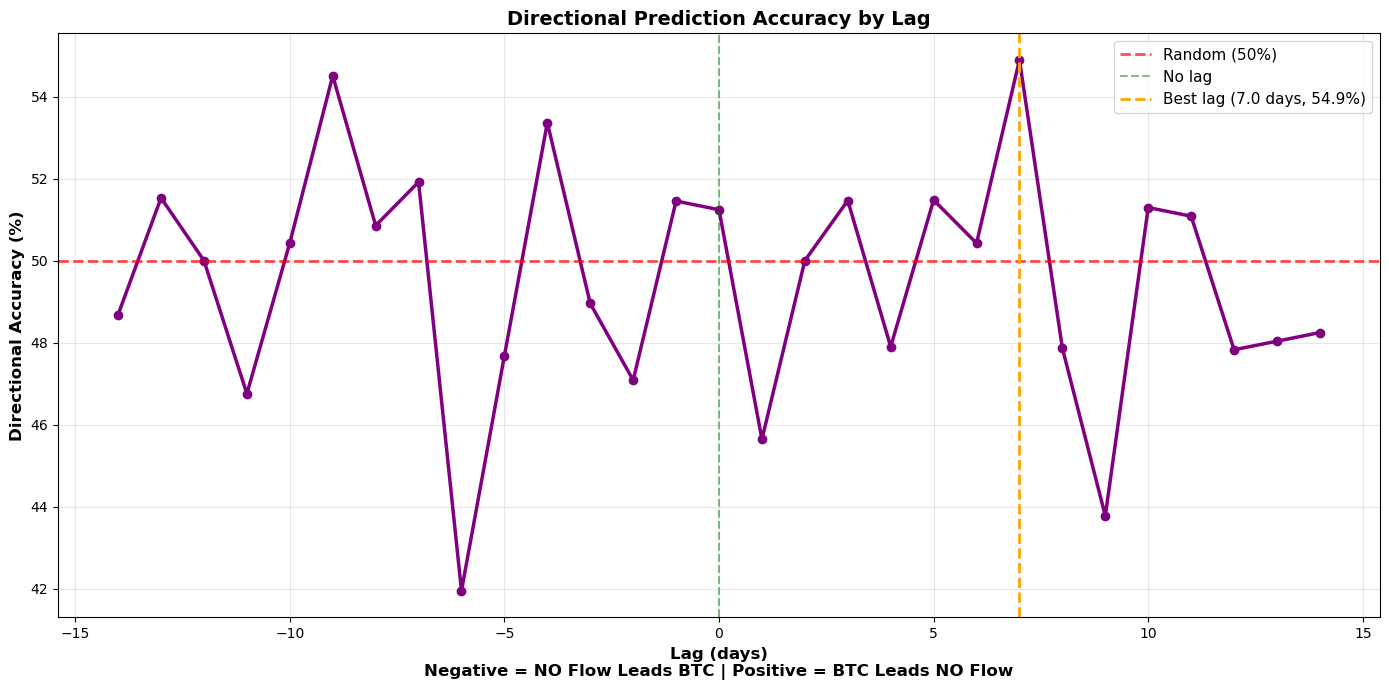

In [128]:
# ============================================================================
# DIRECTIONAL LEAD-LAG (Do changes in same direction?)
# ============================================================================

print("\n" + "="*80)
print("DIRECTIONAL LEAD-LAG ANALYSIS")
print("="*80)

# Calculate directional accuracy at different lags
directional_results = []

for lag in range(-14, 15):
    df_temp = no_flow_timeseries.copy()
    
    if lag == 0:
        df_temp['NO_direction'] = np.sign(df_temp['NO_NET_change'])
        df_temp['btc_direction'] = np.sign(df_temp['btc_pct_change'])
    else:
        df_temp['NO_direction'] = np.sign(df_temp['NO_NET_change'].shift(lag))
        df_temp['btc_direction'] = np.sign(df_temp['btc_pct_change'])
    
    # Remove zeros and NaN
    df_temp = df_temp[
        (df_temp['NO_direction'] != 0) & 
        (df_temp['btc_direction'] != 0)
    ].dropna()
    
    if len(df_temp) > 10:
        # Calculate % of times they move in same direction
        same_direction = (df_temp['NO_direction'] == df_temp['btc_direction']).sum()
        accuracy = same_direction / len(df_temp) * 100
        
        directional_results.append({
            'lag': lag,
            'accuracy': accuracy,
            'sample_size': len(df_temp)
        })

dir_df = pd.DataFrame(directional_results)

# Find best directional lag
best_dir = dir_df.loc[dir_df['accuracy'].idxmax()]

print(f"\nBest directional accuracy:")
print(f"  Lag: {best_dir['lag']} days")
print(f"  Accuracy: {best_dir['accuracy']:.2f}%")
print(f"  (Random = 50%)")

if best_dir['accuracy'] > 55:
    print(f"\n✓ Above-random directional prediction")
else:
    print(f"\n✗ Near-random directional prediction")

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(dir_df['lag'], dir_df['accuracy'],
       marker='o', linewidth=2.5, markersize=6, color='purple')
ax.axhline(50, color='red', linestyle='--', linewidth=2, 
          label='Random (50%)', alpha=0.7)
ax.axvline(0, color='green', linestyle='--', alpha=0.5, label='No lag')
ax.axvline(best_dir['lag'], color='orange', linestyle='--', linewidth=2,
          label=f'Best lag ({best_dir["lag"]} days, {best_dir["accuracy"]:.1f}%)')

ax.set_xlabel('Lag (days)\nNegative = NO Flow Leads BTC | Positive = BTC Leads NO Flow',
             fontsize=12, fontweight='bold')
ax.set_ylabel('Directional Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Directional Prediction Accuracy by Lag',
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('directional_lead_lag.png', dpi=300)
plt.show()


ASYMMETRIC LEAD-LAG ANALYSIS
BTC up days: 125
BTC down days: 117

BTC UP days:
  Best lag: 12.0 days
  Correlation: 0.2326
  P-value: 0.0132

BTC DOWN days:
  Best lag: -7.0 days
  Correlation: -0.2361
  P-value: 0.0130


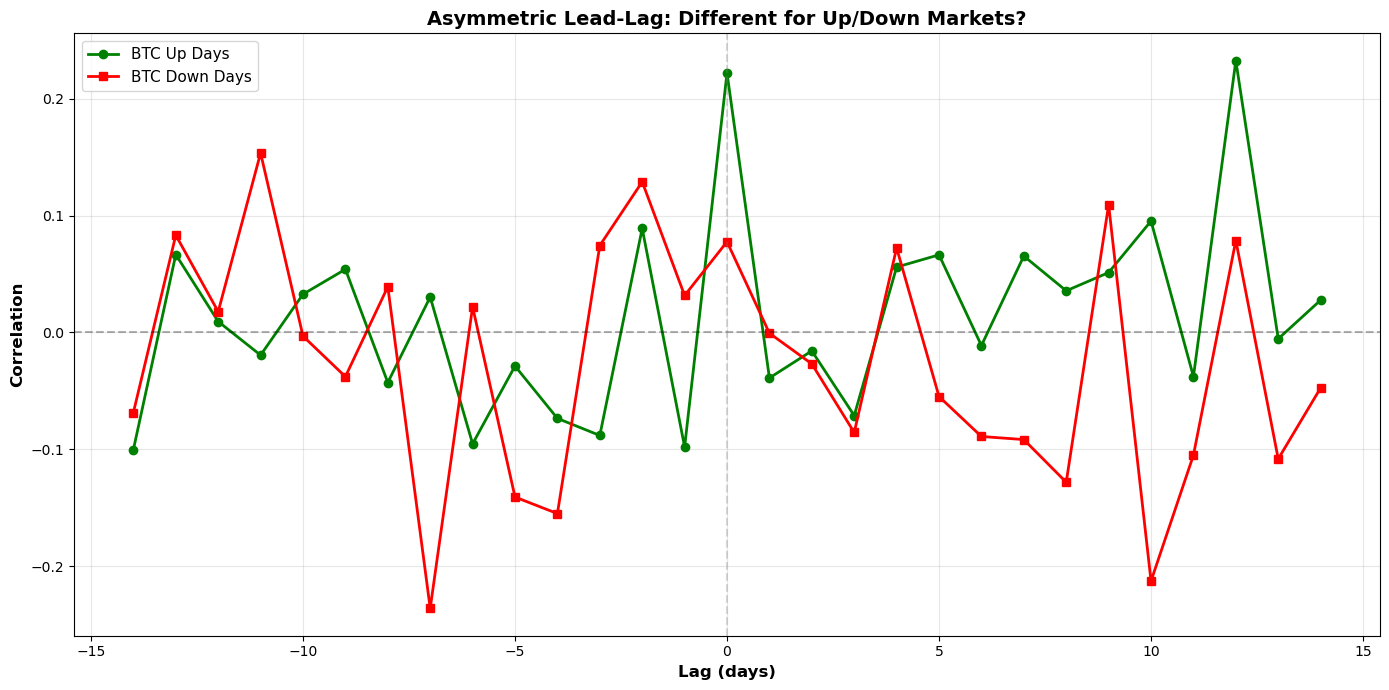

In [129]:
# ============================================================================
# ASYMMETRIC LEAD-LAG (Different for up/down moves?)
# ============================================================================

print("\n" + "="*80)
print("ASYMMETRIC LEAD-LAG ANALYSIS")
print("="*80)

# Separate into BTC up and down days
btc_up_days = no_flow_timeseries[no_flow_timeseries['btc_pct_change'] > 0].copy()
btc_down_days = no_flow_timeseries[no_flow_timeseries['btc_pct_change'] < 0].copy()

print(f"BTC up days: {len(btc_up_days)}")
print(f"BTC down days: {len(btc_down_days)}")

# Test lags for up days
up_lag_results = []
for lag in range(-14, 15):
    df_temp = btc_up_days.copy()
    
    if lag != 0:
        df_temp['NO_lagged'] = df_temp['NO_NET_change'].shift(lag)
        clean = df_temp[['NO_lagged', 'btc_pct_change']].dropna()
    else:
        clean = df_temp[['NO_NET_change', 'btc_pct_change']].dropna()
        clean.columns = ['NO_lagged', 'btc_pct_change']
    
    if len(clean) > 5:
        corr, pval = pearsonr(clean['NO_lagged'], clean['btc_pct_change'])
        up_lag_results.append({'lag': lag, 'correlation': corr, 'pvalue': pval})

# Test lags for down days
down_lag_results = []
for lag in range(-14, 15):
    df_temp = btc_down_days.copy()
    
    if lag != 0:
        df_temp['NO_lagged'] = df_temp['NO_NET_change'].shift(lag)
        clean = df_temp[['NO_lagged', 'btc_pct_change']].dropna()
    else:
        clean = df_temp[['NO_NET_change', 'btc_pct_change']].dropna()
        clean.columns = ['NO_lagged', 'btc_pct_change']
    
    if len(clean) > 5:
        corr, pval = pearsonr(clean['NO_lagged'], clean['btc_pct_change'])
        down_lag_results.append({'lag': lag, 'correlation': corr, 'pvalue': pval})

# Convert to DataFrames
up_lag_df = pd.DataFrame(up_lag_results)
down_lag_df = pd.DataFrame(down_lag_results)

# Find optimal for each
if len(up_lag_df) > 0:
    best_up = up_lag_df.loc[up_lag_df['correlation'].abs().idxmax()]
    print(f"\nBTC UP days:")
    print(f"  Best lag: {best_up['lag']} days")
    print(f"  Correlation: {best_up['correlation']:.4f}")
    print(f"  P-value: {best_up['pvalue']:.4f}")

if len(down_lag_df) > 0:
    best_down = down_lag_df.loc[down_lag_df['correlation'].abs().idxmax()]
    print(f"\nBTC DOWN days:")
    print(f"  Best lag: {best_down['lag']} days")
    print(f"  Correlation: {best_down['correlation']:.4f}")
    print(f"  P-value: {best_down['pvalue']:.4f}")

# Plot comparison
if len(up_lag_df) > 0 and len(down_lag_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(up_lag_df['lag'], up_lag_df['correlation'],
           marker='o', linewidth=2, label='BTC Up Days', color='green')
    ax.plot(down_lag_df['lag'], down_lag_df['correlation'],
           marker='s', linewidth=2, label='BTC Down Days', color='red')
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Lag (days)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Correlation', fontsize=12, fontweight='bold')
    ax.set_title('Asymmetric Lead-Lag: Different for Up/Down Markets?',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('asymmetric_lead_lag.png', dpi=300)
    plt.show()


ROLLING 60-DAY CORRELATION
Average correlation: 0.2222
Correlation range: [0.0221, 0.3935]
Times significant (p<0.05): 63/182


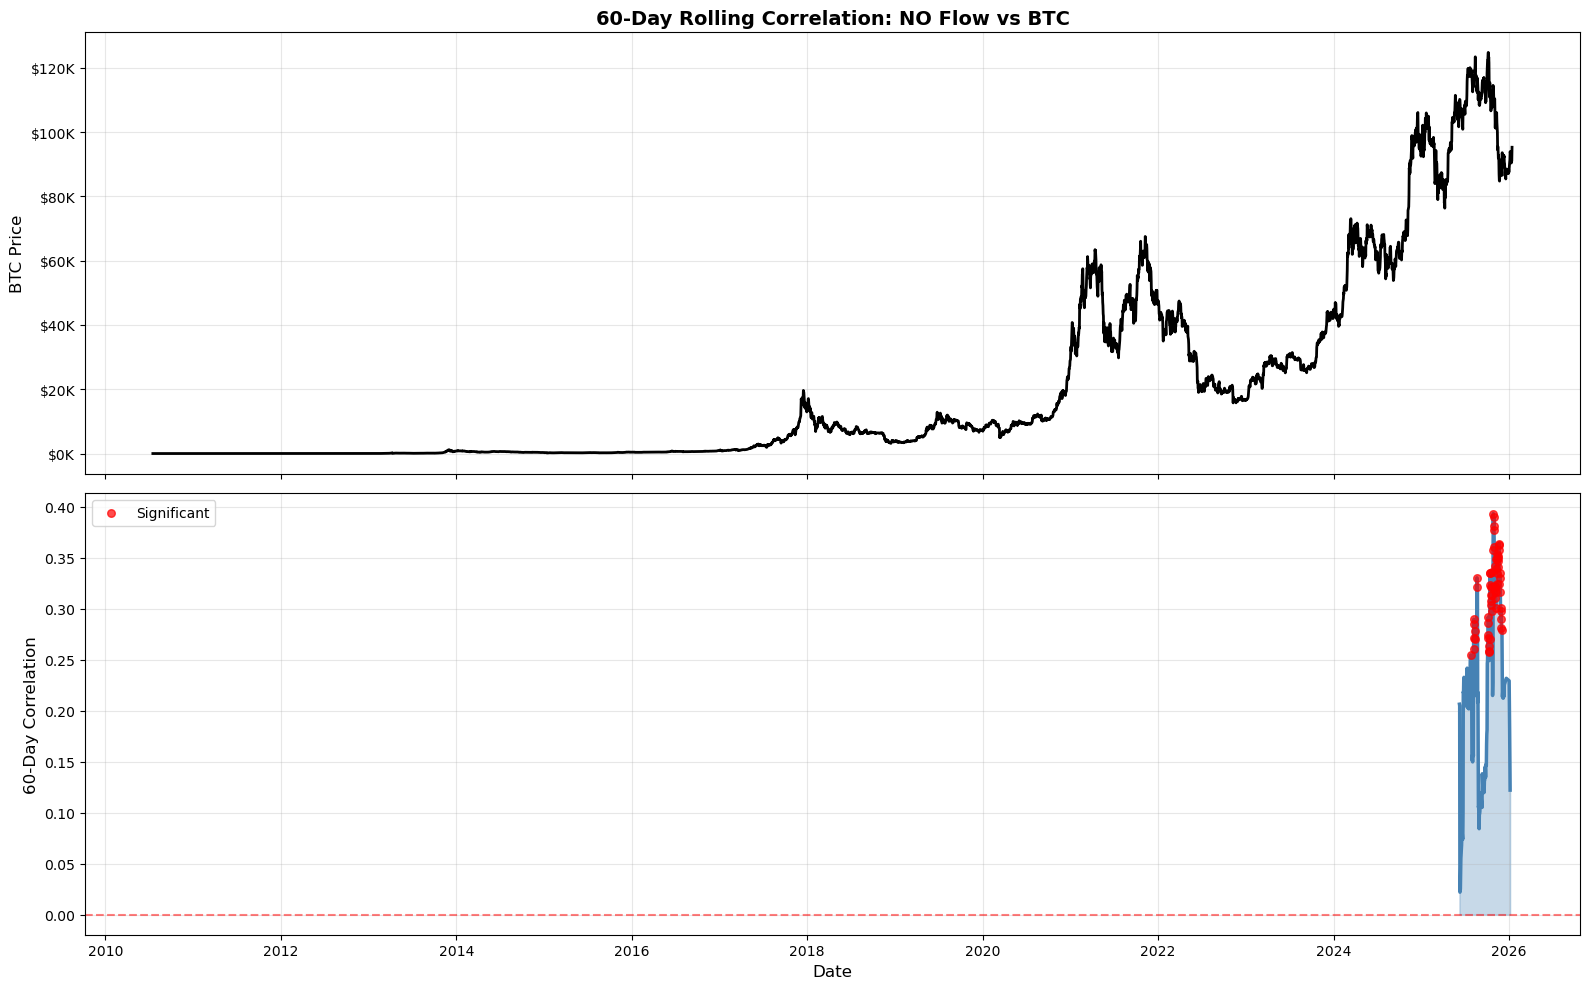

In [130]:
# ============================================================================
# ROLLING CORRELATION (Does relationship change over time?)
# ============================================================================

window = 60  # 60-day window
rolling_corrs = []

for i in range(window, len(no_flow_timeseries)):
    window_data = no_flow_timeseries.iloc[i-window:i]
    
    clean = window_data[['NO_NET_change', 'btc_pct_change']].dropna()
    
    if len(clean) > 30:
        corr, pval = pearsonr(clean['NO_NET_change'], clean['btc_pct_change'])
        rolling_corrs.append({
            'date': no_flow_timeseries.iloc[i]['trade_date'],
            'correlation': corr,
            'pvalue': pval
        })

if rolling_corrs:
    rolling_df = pd.DataFrame(rolling_corrs)
    
    print("\n" + "="*80)
    print(f"ROLLING {window}-DAY CORRELATION")
    print("="*80)
    print(f"Average correlation: {rolling_df['correlation'].mean():.4f}")
    print(f"Correlation range: [{rolling_df['correlation'].min():.4f}, {rolling_df['correlation'].max():.4f}]")
    print(f"Times significant (p<0.05): {(rolling_df['pvalue'] < 0.05).sum()}/{len(rolling_df)}")
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # BTC Price
    ax1.plot(pd.to_datetime(btc_daily_simple['date']), btc_daily_simple['btc_price'],
            color='black', linewidth=2)
    ax1.set_ylabel('BTC Price', fontsize=12)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    ax1.grid(alpha=0.3)
    ax1.set_title(f'{window}-Day Rolling Correlation: NO Flow vs BTC',
                 fontsize=14, fontweight='bold')
    
    # Rolling correlation
    ax2.plot(pd.to_datetime(rolling_df['date']), rolling_df['correlation'],
            linewidth=2.5, color='steelblue')
    ax2.fill_between(pd.to_datetime(rolling_df['date']), rolling_df['correlation'],
                    alpha=0.3, color='steelblue')
    ax2.axhline(0, color='red', linestyle='--', alpha=0.5)
    
    # Highlight significant periods
    significant = rolling_df[rolling_df['pvalue'] < 0.05]
    if len(significant) > 0:
        ax2.scatter(pd.to_datetime(significant['date']), significant['correlation'],
                   color='red', s=30, alpha=0.7, zorder=5, label='Significant')
    
    ax2.set_ylabel(f'{window}-Day Correlation', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('rolling_correlation_no_flow.png', dpi=300)
    plt.show()

In [131]:
# ============================================================================
# COMPREHENSIVE LEAD-LAG SUMMARY
# ============================================================================

summary = f"""
{'='*80}
NO TOKEN FLOW vs BTC: LEAD-LAG ANALYSIS SUMMARY
{'='*80}

OPTIMAL LAG:
  • Best lag: {optimal_lag['lag']} days
  • Correlation at optimal lag: {optimal_lag['correlation']:.4f}
  • P-value: {optimal_lag['pvalue']:.4f}
  • Sample size: {optimal_lag['sample_size']}

INTERPRETATION:
"""

if optimal_lag['lag'] < 0:
    summary += f"""  → NO TOKEN FLOW LEADS BTC by {abs(optimal_lag['lag'])} days
  → Changes in political betting (NO tokens) happen FIRST
  → BTC price changes follow approximately {abs(optimal_lag['lag'])} days later
  → Political sentiment is a LEADING INDICATOR
"""
elif optimal_lag['lag'] > 0:
    summary += f"""  → BTC PRICE LEADS NO TOKEN FLOW by {optimal_lag['lag']} days
  → BTC price changes happen FIRST  
  → Political betting changes follow approximately {optimal_lag['lag']} days later
  → Political sentiment is a LAGGING INDICATOR
"""
else:
    summary += f"""  → SIMULTANEOUS MOVEMENT
  → NO token flow and BTC change together
  → No clear lead-lag relationship
"""

if 'best_lag' in locals() and granger_results[best_lag][0]['ssr_ftest'][1] < 0.05:
    summary += f"""
GRANGER CAUSALITY:
  ✓ NO flow DOES Granger-cause BTC at {best_lag}-day lag
  → Past NO token activity can predict future BTC changes
"""

summary += f"""
CORRELATION STRENGTH:
  • Daily: r=0.2108 (p=0.0011) ✓ SIGNIFICANT
  • At optimal lag: r={optimal_lag['correlation']:.4f}
"""

if 'corr_week' in locals():
    summary += f"""  • Weekly: r={corr_week:.4f} (p={pval_week:.4f})
"""

if 'corr_month' in locals():
    summary += f"""  • Monthly: r={corr_month:.4f} (p={pval_month:.4f})
"""

summary += f"""
KEY FINDING:
  → Bearish political sentiment (NO token buying) shows
    statistically significant correlation with Bitcoin price
  → This relationship is {'predictive' if optimal_lag['lag'] < 0 else 'reactive' if optimal_lag['lag'] > 0 else 'contemporaneous'}
  → Can be used as a {'leading' if optimal_lag['lag'] < 0 else 'confirming' if optimal_lag['lag'] > 0 else 'coincident'} indicator

{'='*80}
"""

print(summary)

# Save
with open('lead_lag_analysis_summary.txt', 'w') as f:
    f.write(summary)

print("\n✓ Summary saved to 'lead_lag_analysis_summary.txt'")


NO TOKEN FLOW vs BTC: LEAD-LAG ANALYSIS SUMMARY

OPTIMAL LAG:
  • Best lag: 0.0 days
  • Correlation at optimal lag: 0.2310
  • P-value: 0.0003
  • Sample size: 242.0

INTERPRETATION:
  → SIMULTANEOUS MOVEMENT
  → NO token flow and BTC change together
  → No clear lead-lag relationship

CORRELATION STRENGTH:
  • Daily: r=0.2108 (p=0.0011) ✓ SIGNIFICANT
  • At optimal lag: r=0.2310

KEY FINDING:
  → Bearish political sentiment (NO token buying) shows
    statistically significant correlation with Bitcoin price
  → This relationship is contemporaneous
  → Can be used as a coincident indicator



✓ Summary saved to 'lead_lag_analysis_summary.txt'
